# DSCI 619 Final Project
### Lauren Schmiedeler

## Part I

##### Load the required libraries.

In [1]:
import os
from pathlib import Path
from PIL import Image
from IPython.display import display
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Rescaling, Dropout
import visualkeras
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

##### Set a theme for the plots.

In [2]:
sns.set_theme()

##### Create a list that contains the names of the three models used.

In [3]:
models = ["Basic", "Data Aug + Dropout", "ConvNeXtTiny"]

##### Create helper functions.

In [4]:
def find_true_and_predicted_labels(model, val_data):
    true_labels = []
    predicted_labels = []
    for img, lab in val_data:
        true_labels.extend(list(lab.numpy()))
        predicted_labels.extend(list(np.argmax(model.predict(img, verbose = 0), axis = 1)))
    return pd.DataFrame({"true": true_labels, "predicted": predicted_labels})

`sklearn.metrics.balanced_accuracy_score` computes the balanced accuracy.

The balanced accuracy in binary and multiclass classification problems to deal with imbalanced datasets. **It is defined as the average of recall obtained on each class.**

**The best value is 1 and the worst value is 0** when `adjusted = False`.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.balanced_accuracy_score.html#sklearn.metrics.balanced_accuracy_score

In [5]:
def compute_test_accuracy(true_and_predicted, balanced = False):
    if not balanced:
        return accuracy_score(y_true = true_and_predicted.true, y_pred = true_and_predicted.predicted)
    else:
        return balanced_accuracy_score(y_true = true_and_predicted.true, y_pred = true_and_predicted.predicted)

In the multi-class and multi-label case, `sklearn.metrics.f1_score` is the average of the F1 score of each class with **weighting depending on the `average` parameter**.
+ `average = "macro"`: Calculate metrics for each label, and find their unweighted mean. **This does not take label imbalance into account.**
+ `average = "weighted"`: Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). **This alters ‘macro’ to account for label imbalance**; it can result in an F-score that is not between precision and recall.

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

In [6]:
def compute_test_f1_score(true_and_predicted, average = "macro"):
    return f1_score(y_true = true_and_predicted.true, y_pred = true_and_predicted.predicted, average = average)

In [7]:
def compute_test_metrics(true_and_predicted, model):
    return pd.DataFrame({"model": [model], "accuracy": [round(compute_test_accuracy(true_and_predicted), 4)],
                        "balanced_accuracy": [round(compute_test_accuracy(true_and_predicted, balanced = True), 4)],
                        "f1": [round(compute_test_f1_score(true_and_predicted), 4)],
                        "weighted_f1": [round(compute_test_f1_score(true_and_predicted, average = "weighted"), 4)]})

In [8]:
# metrics = ["accuracy", "precision", "recall", "f1"]
def compute_test_metrics_by_category(true_and_predicted, categories):
    # use the confusion matrix to find the test accuracy by category
    cm = confusion_matrix(y_true = true_and_predicted.true, y_pred = true_and_predicted.predicted)
    return pd.DataFrame({"category": categories, "correct": list(cm.diagonal()), "total": list(cm.sum(axis = 1)), 
                         "accuracy": list(cm.diagonal() / cm.sum(axis = 1)),
                         "precision": precision_score(y_true = true_and_predicted.true, y_pred = true_and_predicted.predicted, average = None),
                         "recall": recall_score(y_true = true_and_predicted.true, y_pred = true_and_predicted.predicted, average = None),
                         "f1": f1_score(y_true = true_and_predicted.true, y_pred = true_and_predicted.predicted, average = None)})

In [9]:
def plot_test_metric_by_category(metrics_by_category, metric = "accuracy"):
    plt.figure(figsize = (20, 5))
    # create a barplot that show the specified metric for each category
    graph = sns.barplot(data = metrics_by_category.sort_values(metric, ascending = False), x = "category", y = metric)
    # add a horizontal dotted line at 0.5
    graph.axhline(0.5, ls = "--")
    plt.xlabel("Category", fontsize = 14)
    plt.xticks(rotation = 90, fontsize = 12)
    plt.ylabel("Test " + metric.title(), fontsize = 14)
    plt.yticks(fontsize = 12)
    plt.title("Test " + metric.title() + " by Category", fontsize = 18);

In [10]:
def plot_confusion_matrix(true_and_predicted, categories):
    cmap = sns.diverging_palette(h_neg = 225, h_pos = 125, l = 75, as_cmap = True)
    plt.figure(figsize = (25, 35))
    cm = confusion_matrix(y_true = true_and_predicted.true, y_pred = true_and_predicted.predicted, normalize = "true")
    ax = sns.heatmap(cm, xticklabels = categories, yticklabels = categories, linewidths = 1.5, linecolor = "black", cmap = cmap, cbar_kws = {"location": "bottom", "shrink": 0.5, "pad": 0.13})
    cbar = ax.collections[0].colorbar
    cbar.ax.tick_params(labelsize = 30)
    ax.set_yticklabels(ax.get_yticklabels(), size = 20)
    ax.set_xticklabels(ax.get_xticklabels(), size = 20)
    plt.xlabel("Predicted Category", fontsize = 30)
    plt.ylabel("True Category", fontsize = 30)
    plt.title("Confusion Matrix", fontsize = 40);

In [11]:
def plot_loss_and_accuracy(history):
    plt.figure(figsize = (12, 4))
    plt.subplot(1, 2, 1)
    train_history = pd.DataFrame(history.history)
    train_history["epoch"] = history.epoch
    sns.lineplot(x = "epoch", y = "loss", data = train_history, label = "Train Loss")
    sns.lineplot(x = "epoch", y = "val_loss", data = train_history, label = "Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train and Validation Loss")
    plt.subplot(1, 2, 2)
    sns.lineplot(x = "epoch", y = "accuracy", data = train_history, label = "Train Accuracy")
    sns.lineplot(x = "epoch", y = "val_accuracy", data = train_history, label = "Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Train and Validation Accuracy");

#### 1. Download the dataset that is about 3GB from Kaggle into the local disk and unzip it.

##### Find the number of categories.

In [12]:
img_dir = os.listdir("Images")
print("number of categories =", len(img_dir))

number of categories = 61


##### Find and plot the number of images in each category.

In [13]:
images_per_category = pd.DataFrame(columns = ["category", "n_images"])
img_dir_path = Path(os.getcwd() + "\\Images")
total_images = 0
for root, dirs, images in os.walk(img_dir_path):
    if os.path.basename(root) != "Images":
        images_per_category = pd.concat([images_per_category, pd.DataFrame([[os.path.basename(root), len(images)]], columns = ["category", "n_images"])])
    total_images += len(images)
images_per_category = images_per_category.reset_index(drop = True)

In [14]:
print("total number of images =", sum(images_per_category.n_images))

total number of images = 14056


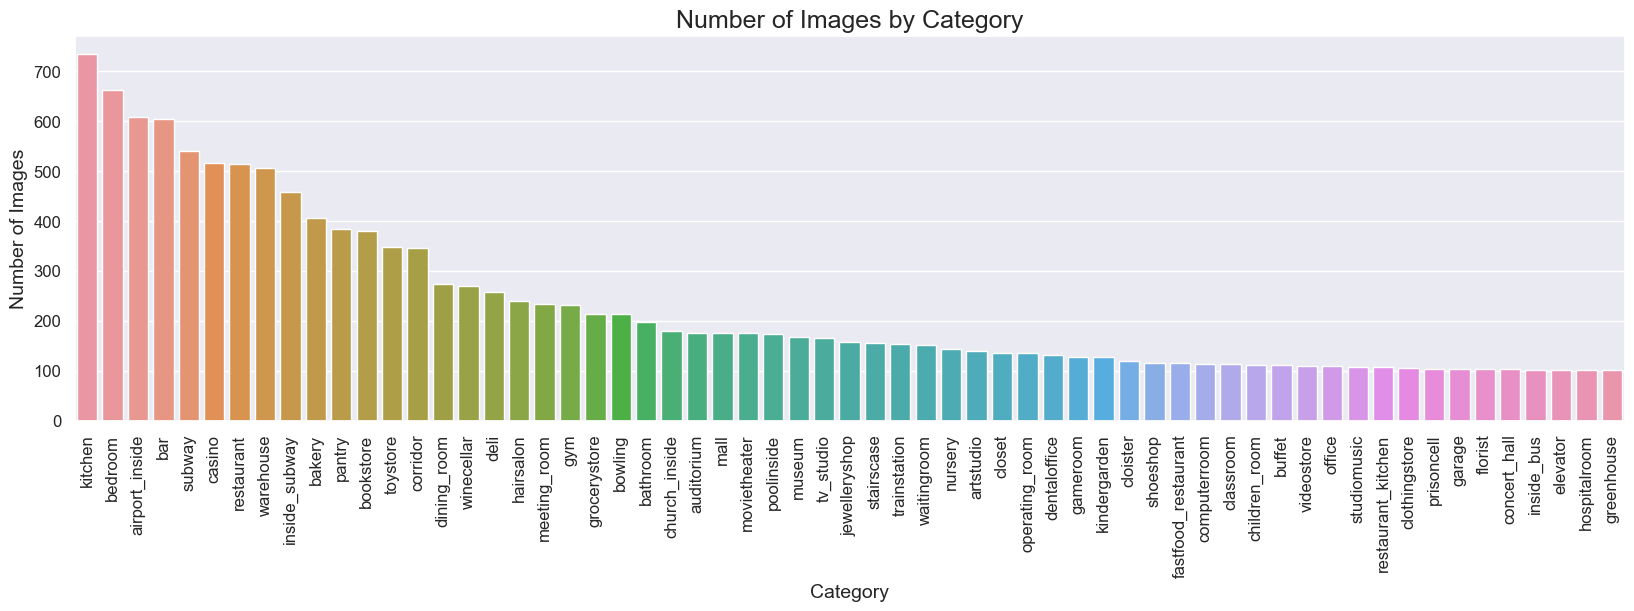

In [15]:
plt.figure(figsize = (20, 5))
sns.barplot(data = images_per_category.sort_values("n_images", ascending = False), x = "category", y = "n_images")
plt.xlabel("Category", fontsize = 14)
plt.xticks(rotation = 90, fontsize = 12)
plt.ylabel("Number of Images", fontsize = 14)
plt.yticks(fontsize = 12)
plt.title("Number of Images by Category", fontsize = 18);

##### View some of the images and their corresponding labels as well as their sizes.

image size = (500, 368, 3)
label = airport_inside


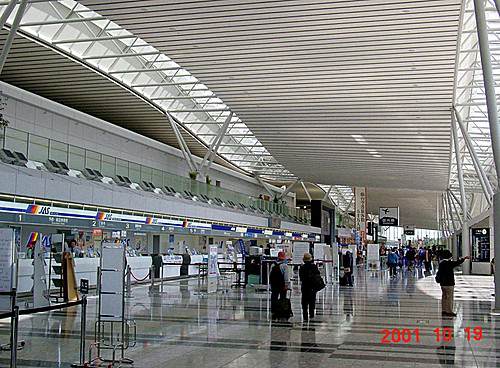

image size = (290, 217, 3)
label = artstudio


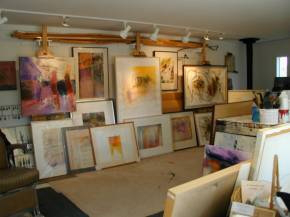

image size = (540, 358, 3)
label = auditorium


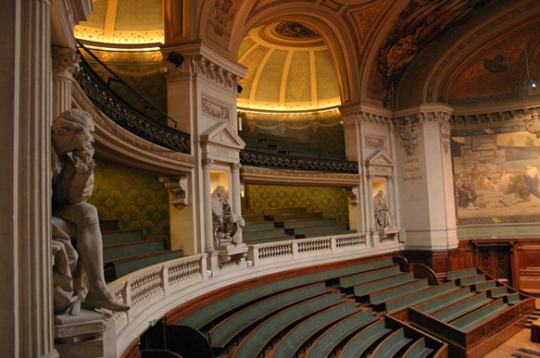

image size = (256, 256, 3)
label = bakery


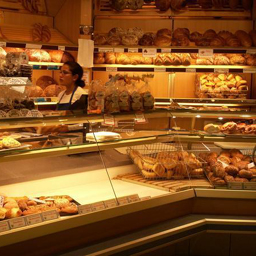

image size = (256, 256, 3)
label = bar


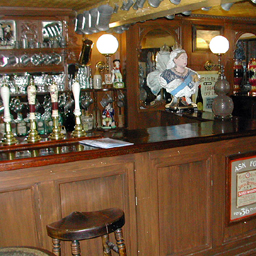

In [16]:
for i in range(5):
    img = Image.open("Images/" + img_dir[i] + "/" + os.listdir("Images/" + img_dir[i])[0])
    print(f"image size = ({img.size[0]}, {img.size[1]}, {len(img.mode)})\nlabel = {img_dir[i]}")
    display(img)

##### Create a training dataset (70% of the data) and a test dataset (30% of the data).

In [17]:
batch_size = 32
image_height = 128
image_width = 128
image_channels = 3
train_test_split = 0.3

# training data
train_data = tf.keras.preprocessing.image_dataset_from_directory(
  os.getcwd() + "\\Images",
  labels = "inferred",
  label_mode = "int",
  validation_split = train_test_split,
  subset = "training",
  seed = 100,
  image_size = (image_height, image_width),
  batch_size = batch_size)

# validation (test) data
val_data = tf.keras.preprocessing.image_dataset_from_directory(
  os.getcwd() + "\\Images", 
  labels = "inferred",
  label_mode = "int",
  validation_split = train_test_split,
  subset = "validation",
  seed = 100,
  image_size = (image_height, image_width),
  batch_size = batch_size)

Found 14056 files belonging to 61 classes.
Using 9840 files for training.
Found 14056 files belonging to 61 classes.
Using 4216 files for validation.


##### Display the images and their corresponding labels in one batch of the training data (32 images and labels).

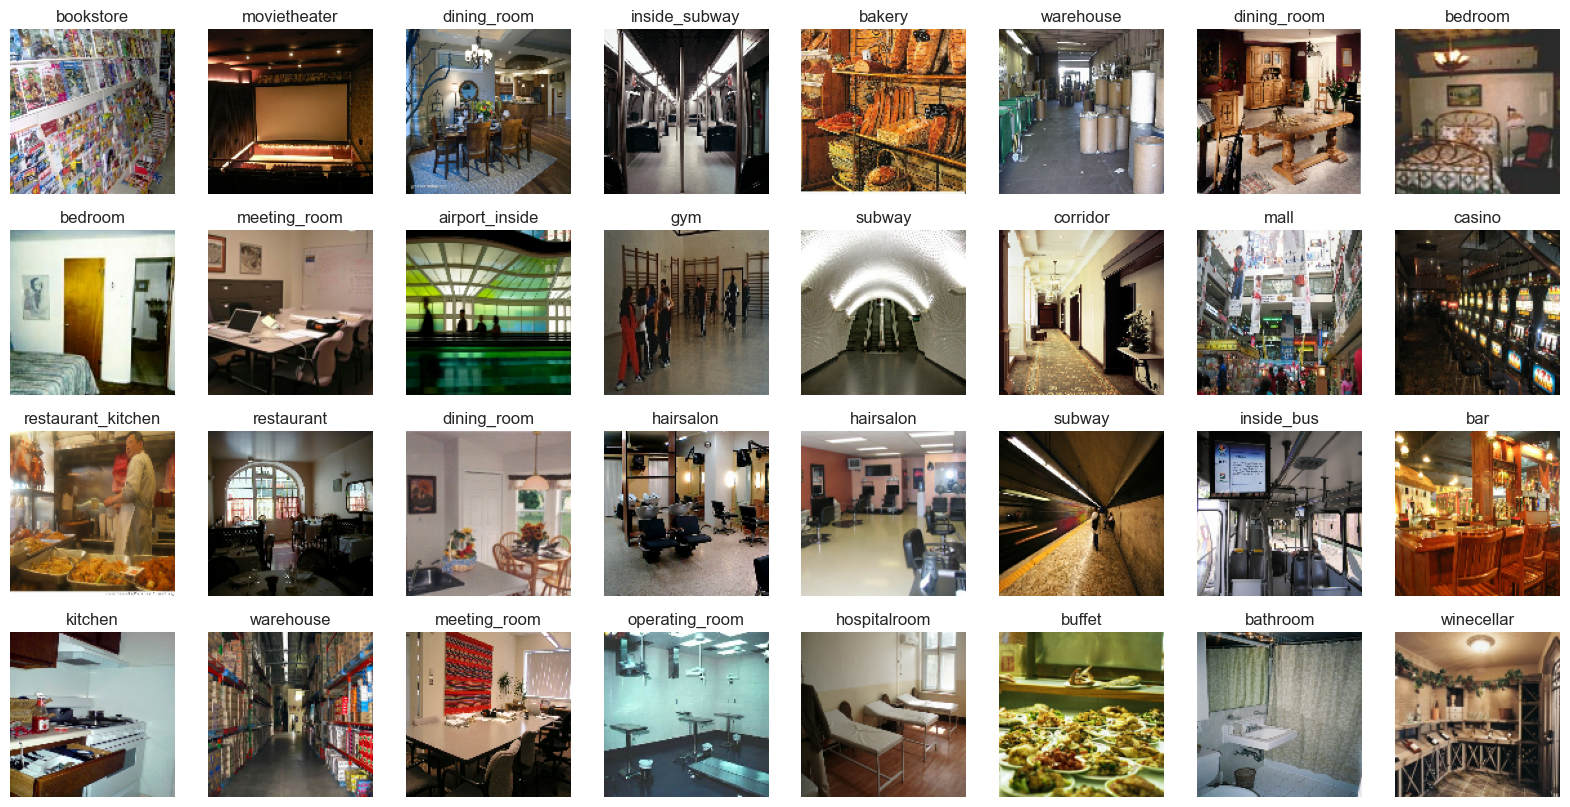

In [18]:
plt.figure(figsize = (20, 10))
for img, lab in train_data.take(1):
    for i in range(batch_size):
        ax = plt.subplot(4, 8, i + 1)
        plt.imshow(img[i].numpy().astype("uint16"))
        plt.title(img_dir[lab[i]]) 
        plt.axis("off")

#### 2. Build a baseline CNN model on the training dataset and evaluate it on the test dataset.

##### Build and view a baseline CNN model.

In [19]:
model_1 = Sequential()

# scale the data
model_1.add(Rescaling(1.0/255.0, input_shape = (image_height, image_width, image_channels)))

# add convolution and maximum pooling layers
model_1.add(Conv2D(filters = 16, kernel_size = 3, padding = "same", activation = "relu"))
model_1.add(MaxPool2D(padding = "same"))
model_1.add(Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"))
model_1.add(MaxPool2D(padding = "same"))
model_1.add(Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"))
model_1.add(MaxPool2D(padding = "same"))
model_1.add(Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = "relu"))
model_1.add(MaxPool2D(padding = "same"))

# convert the output to 2D
model_1.add(Flatten())

# add classification layers
model_1.add(Dense(units = 256, activation = "relu"))
model_1.add(Dense(units = len(img_dir), activation = "softmax"))

model_1.build(input_shape = (batch_size, image_height, image_width, image_channels))

model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        1

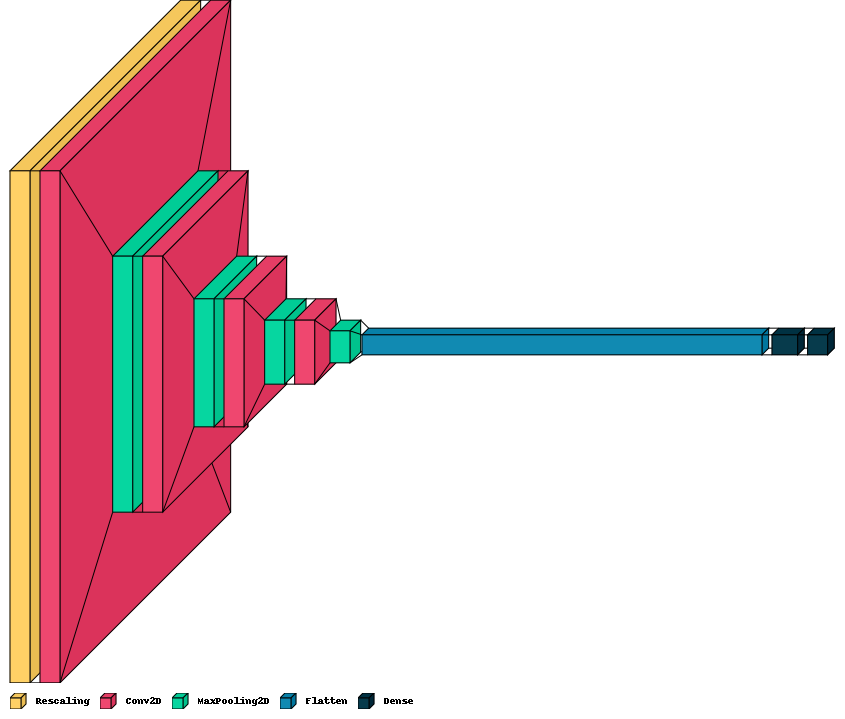

In [20]:
visualkeras.layered_view(model_1, legend = True)

##### Compile the model and train it on the training dataset.

In [21]:
%%time
# compile the model
model_1.compile(optimizer = "rmsprop", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
# add early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 3)
# train the model
history_1 = model_1.fit(train_data, validation_data = val_data, epochs = 20, callbacks = [callback])

Epoch 1/20
308/308 [==============================] - 116s 374ms/step - loss: 3.7578 - accuracy: 0.0865 - val_loss: 3.4699 - val_accuracy: 0.1487
Epoch 2/20
308/308 [==============================] - 116s 376ms/step - loss: 3.3423 - accuracy: 0.1651 - val_loss: 3.1921 - val_accuracy: 0.1760
Epoch 3/20
308/308 [==============================] - 95s 306ms/step - loss: 3.0347 - accuracy: 0.2238 - val_loss: 3.5142 - val_accuracy: 0.1599
Epoch 4/20
308/308 [==============================] - 106s 341ms/step - loss: 2.7096 - accuracy: 0.2869 - val_loss: 2.9977 - val_accuracy: 0.2372
Epoch 5/20
308/308 [==============================] - 107s 347ms/step - loss: 2.3145 - accuracy: 0.3861 - val_loss: 3.1211 - val_accuracy: 0.2400
Epoch 6/20
308/308 [==============================] - 109s 351ms/step - loss: 1.7770 - accuracy: 0.5091 - val_loss: 3.6080 - val_accuracy: 0.2453
Epoch 7/20
308/308 [==============================] - 108s 349ms/step - loss: 1.1468 - accuracy: 0.6728 - val_loss: 4.1892 - 

##### Make predictions on the test dataset using the model.

In [22]:
%%time
true_and_predicted_1 = find_true_and_predicted_labels(model_1, val_data)

CPU times: total: 22.7 s
Wall time: 20.7 s


##### Evaluate the model by finding its test metrics:
+ accuracy
+ balanced accuracy
+ f1
+ weighted f1

In [23]:
test_metrics_1 = compute_test_metrics(true_and_predicted_1, models[0])

In [24]:
test_metrics_1

model  accuracy  balanced_accuracy      f1  weighted_f1
0  Basic    0.2151             0.1673  0.1671       0.2034

In [25]:
model = test_metrics_1.iloc[0,0]
temp = test_metrics_1.transpose().iloc[1:]
temp["metric"] = temp.index
temp = temp.reset_index(drop = True)
temp.columns = ["value", "metric"]
temp = temp[["metric", "value"]]

In [26]:
print("Model:", model)
temp

Model: Basic


metric   value
0           accuracy  0.2151
1  balanced_accuracy  0.1673
2                 f1  0.1671
3        weighted_f1  0.2034

##### Evaluate the model by finding its test metrics by category:
+ accuracy
+ precision
+ recall
+ f1

In [27]:
metrics_by_category_1 = compute_test_metrics_by_category(true_and_predicted_1, img_dir)

In [28]:
metrics_by_category_1.sort_values("accuracy", ascending = False)

category  correct  total  accuracy  precision    recall  \
46           poolinside       29     46  0.630435   0.381579  0.630435   
19             corridor       59    104  0.567308   0.335227  0.567308   
59            warehouse       88    164  0.536585   0.185654  0.536585   
37              kitchen       96    203  0.472906   0.217195  0.472906   
5              bathroom       24     56  0.428571   0.181818  0.428571   
..                  ...      ...    ...       ...        ...       ...   
24  fastfood_restaurant        0     36  0.000000   0.000000  0.000000   
50             shoeshop        0     42  0.000000   0.000000  0.000000   
47           prisoncell        0     33  0.000000   0.000000  0.000000   
42              nursery        0     38  0.000000   0.000000  0.000000   
1             artstudio        0     31  0.000000   0.000000  0.000000   

          f1  
46  0.475410  
19  0.421429  
59  0.275862  
37  0.297674  
5   0.255319  
..       ...  
24  0.000000  
50  0.000000  
47  0.000000  
42  0.000000  
1   0.000000  

[61 rows x 7 columns]

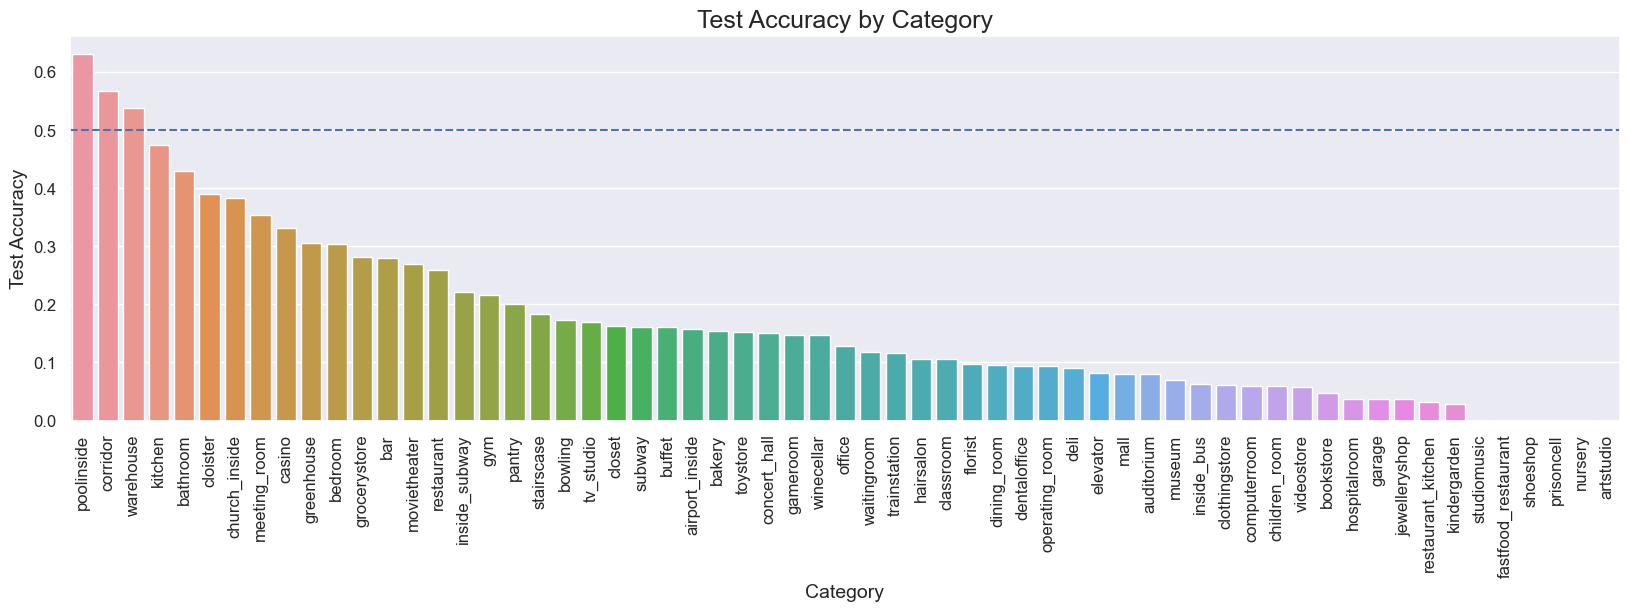

In [29]:
plot_test_metric_by_category(metrics_by_category_1)

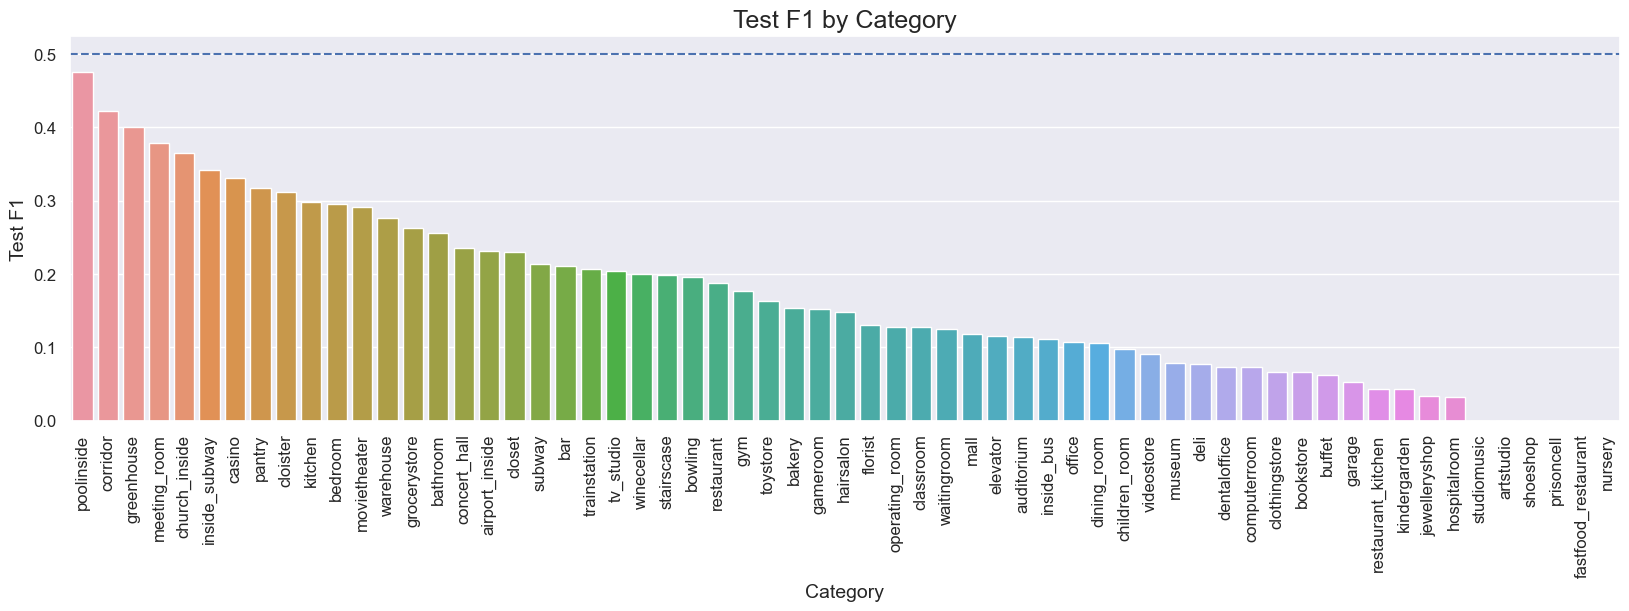

In [30]:
plot_test_metric_by_category(metrics_by_category_1, metric = "f1")

##### Find the proportion of categories that have accuracies greater than 50%.

In [31]:
print("proportion of categories with accuracies greater than 50% =", round(sum(metrics_by_category_1.accuracy > 0.5)/len(metrics_by_category_1), 4))

proportion of categories with accuracies greater than 50% = 0.0492


##### Plot a confusion matrix for the model.

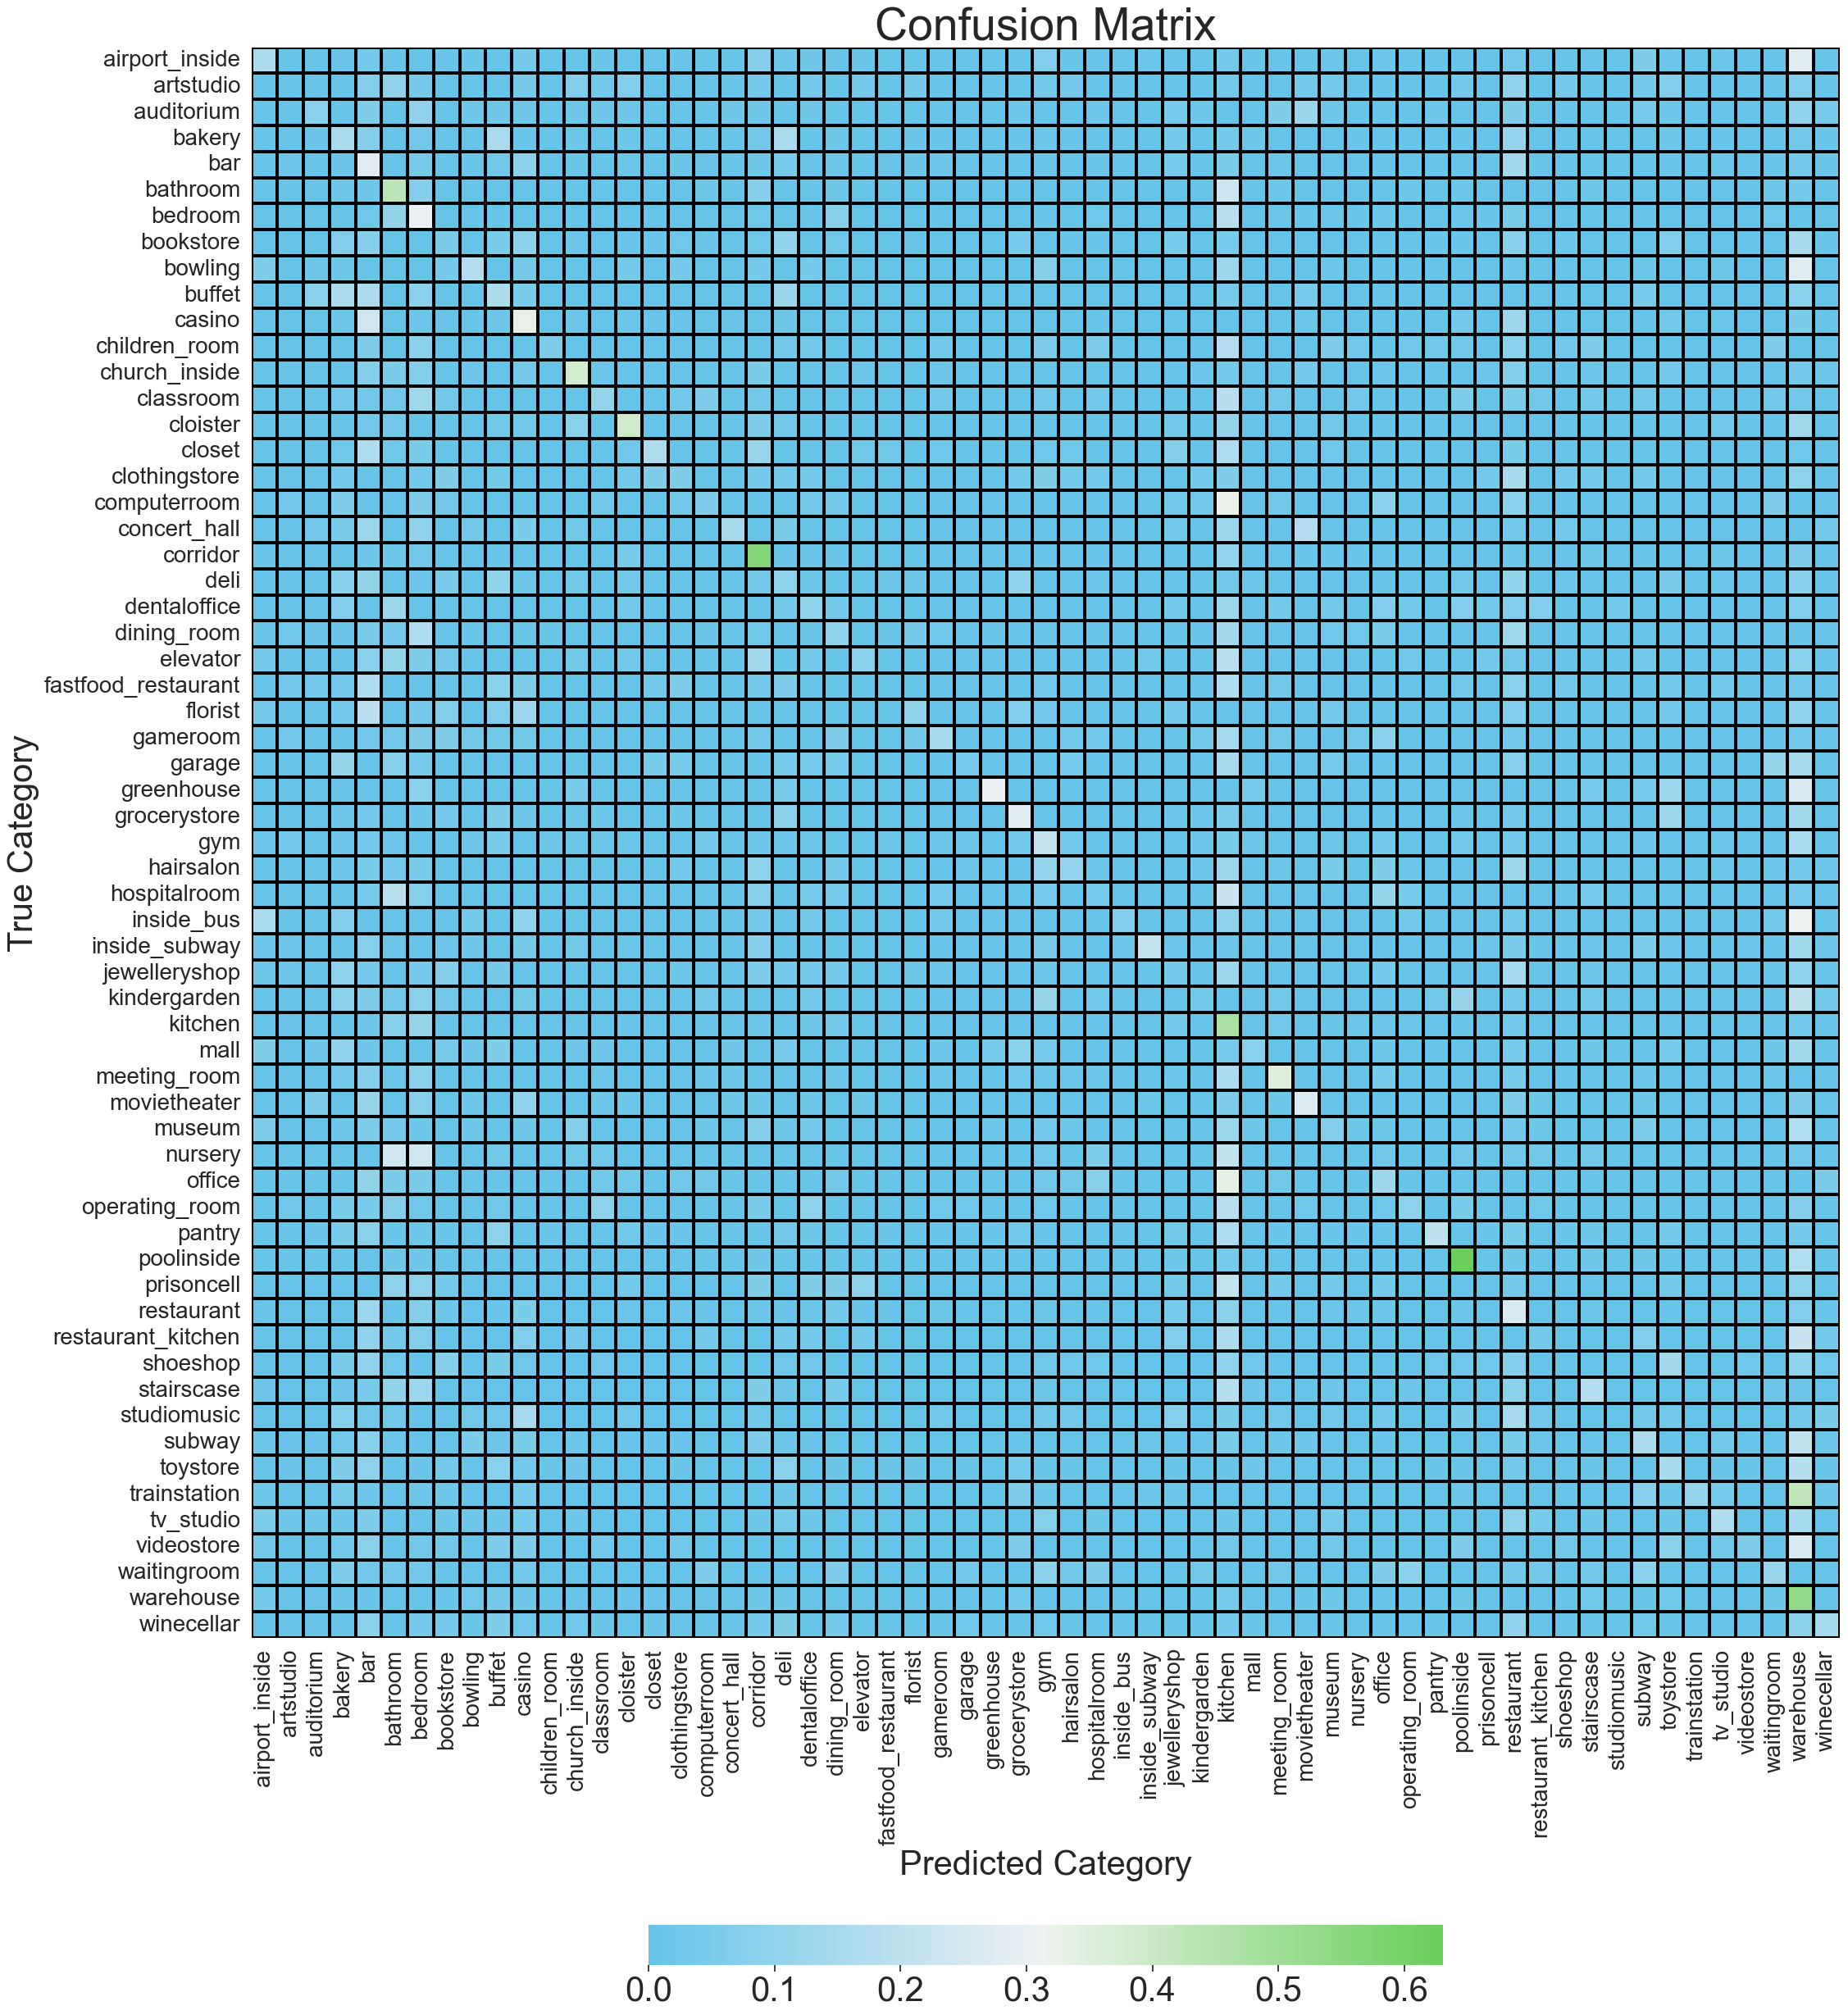

In [32]:
plot_confusion_matrix(true_and_predicted_1, img_dir)

##### Plot the training and validation loss and accuracy for each epoch of training.

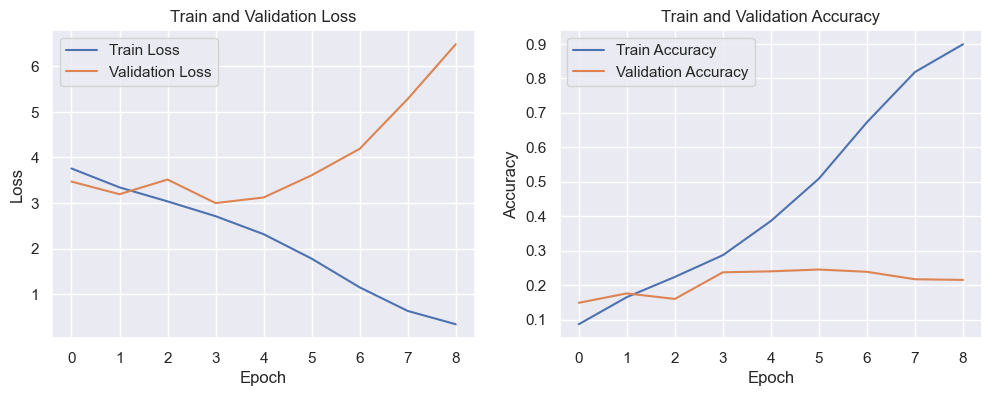

In [33]:
plot_loss_and_accuracy(history_1)

#### 3. Build a second CNN model with data augmentation and dropout and evaluate it on the test dataset.

##### Create a data augmentation layer.

In [34]:
# disable tensorflow warnings
tf.get_logger().setLevel("ERROR")

# generate more image inputs using data augmentation
data_aug = tf.keras.Sequential(
    [
        tf.keras.layers.experimental.preprocessing.RandomContrast(factor = 0.5),
        tf.keras.layers.experimental.preprocessing.RandomFlip(mode = "horizontal"),
        tf.keras.layers.experimental.preprocessing.RandomRotation(factor = 0.1),
        tf.keras.layers.experimental.preprocessing.RandomTranslation(height_factor = 0.1, width_factor = 0.1),
        tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = 0.1, width_factor = 0.1)
  ]
)

##### Display some augmented images.

The original image is the left-most image in each row.

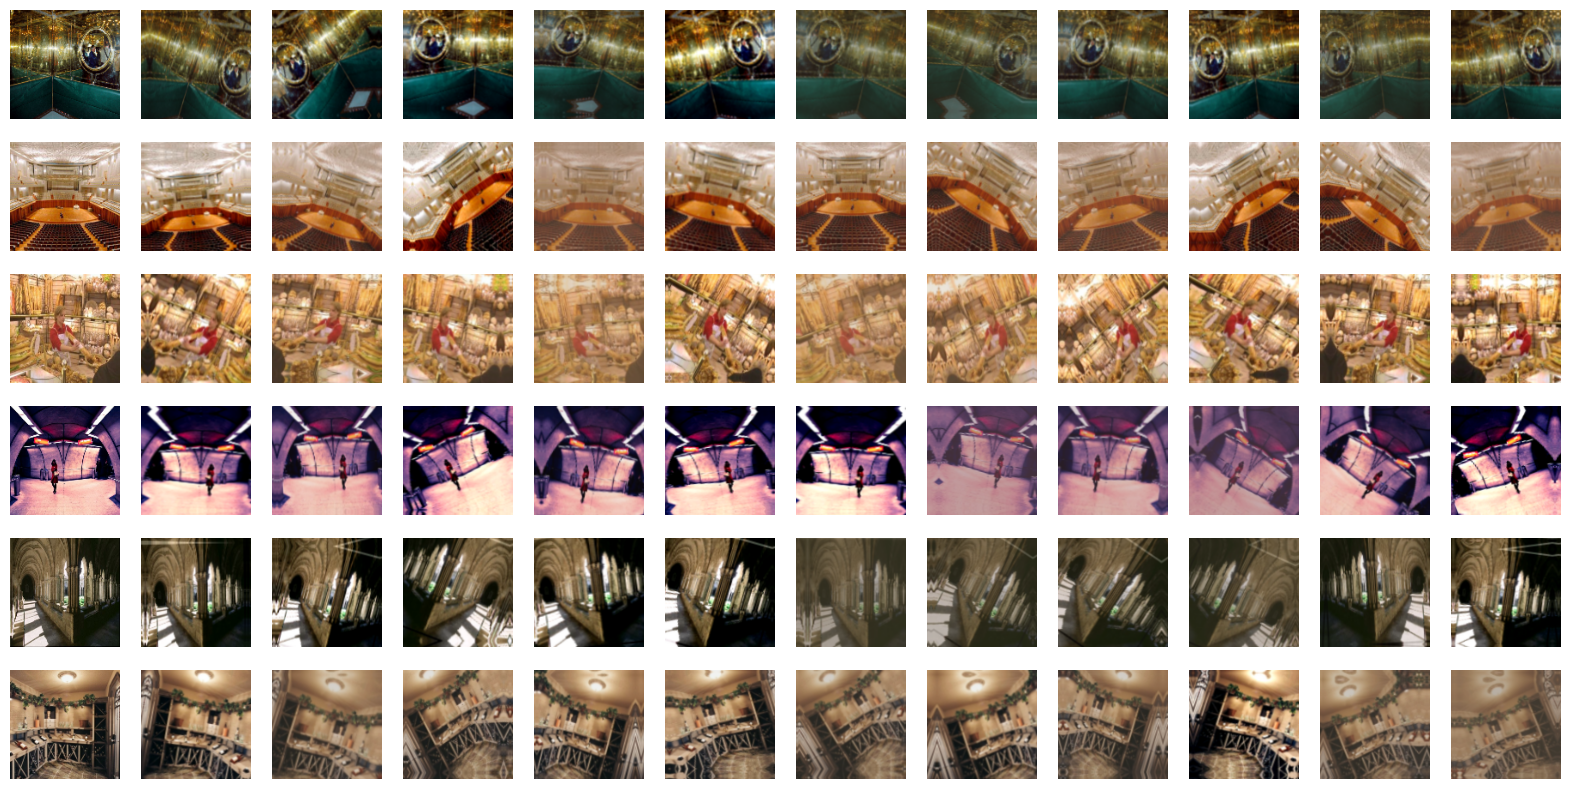

In [35]:
nrow = 6
ncol = 12
fig, axes = plt.subplots(nrows = nrow, ncols = ncol, figsize = (20, 10))
n = 0
for img, lab in train_data.take(1):
    for i in range(nrow):
        for j in range(ncol):
            if n % ncol == 0:
                ax = axes.flatten()[n]
                ax.imshow(img[i].numpy().astype("uint16"))
                ax.axis("off")
            else:
                new_img = data_aug(img)
                ax = axes.flatten()[n]
                ax.imshow(new_img[i].numpy().astype("uint16"))
                ax.axis("off")
            n = n + 1

##### Build and view a CNN model with data augmentation and dropout.

In [36]:
model_2 = Sequential()

# augment the data
model_2.add(data_aug)

# scale the data
model_2.add(Rescaling(1.0/255.0, input_shape = (image_height, image_width, image_channels)))

# add convolution and maximum pooling layers
model_2.add(Conv2D(filters = 16, kernel_size = 3, padding = "same", activation = "relu"))
model_2.add(MaxPool2D(padding = "same"))
model_2.add(Conv2D(filters = 32, kernel_size = 3, padding = "same", activation = "relu"))
model_2.add(MaxPool2D(padding = "same"))
model_2.add(Conv2D(filters = 64, kernel_size = 3, padding = "same", activation = "relu"))
model_2.add(MaxPool2D(padding = "same"))
model_2.add(Conv2D(filters = 128, kernel_size = 3, padding = "same", activation = "relu"))
model_2.add(MaxPool2D(padding = "same"))

# convert the output to 2D
model_2.add(Flatten())

# add a dropout layer to limit overfitting
model_2.add(Dropout(0.2))

# add classification layers
model_2.add(Dense(units = 256, activation = "relu"))
model_2.add(Dense(units = len(img_dir), activation = "softmax"))

model_2.build(input_shape = (batch_size, image_height, image_width, image_channels))

model_2.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (32, 128, 128, 3)         0         
                                                                 
 rescaling_1 (Rescaling)     (32, 128, 128, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (32, 128, 128, 16)        448       
                                                                 
 max_pooling2d_4 (MaxPooling  (32, 64, 64, 16)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (32, 64, 64, 32)          4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (32, 32, 32, 32)         0         
 2D)                                                  

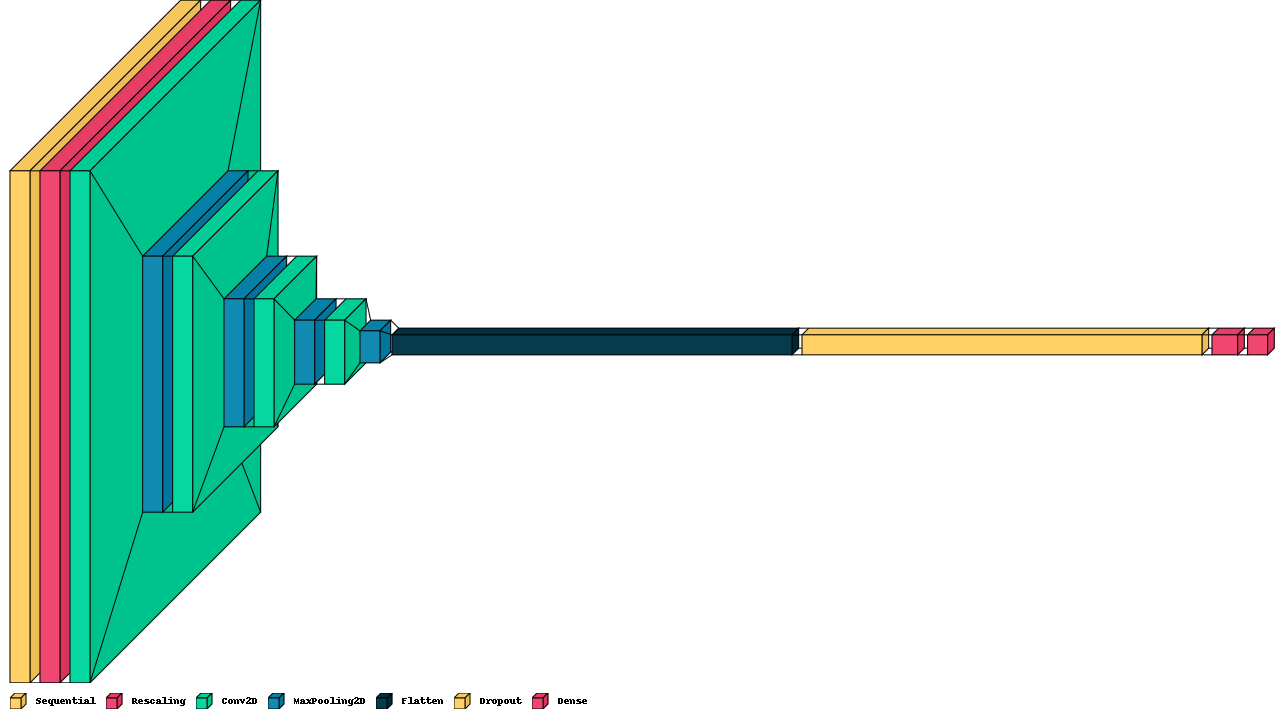

In [37]:
visualkeras.layered_view(model_2, legend = True)

##### Compile the model and train it on the training dataset.

In [38]:
%%time
# compile the model
model_2.compile(optimizer = "rmsprop", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
# add early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 4)
# train the model
history_2 = model_2.fit(train_data, validation_data = val_data, epochs = 25, callbacks = [callback])

Epoch 1/25
308/308 [==============================] - 131s 417ms/step - loss: 3.8699 - accuracy: 0.0657 - val_loss: 3.7652 - val_accuracy: 0.0799
Epoch 2/25
308/308 [==============================] - 126s 408ms/step - loss: 3.6479 - accuracy: 0.1046 - val_loss: 3.6622 - val_accuracy: 0.1079
Epoch 3/25
308/308 [==============================] - 127s 409ms/step - loss: 3.4912 - accuracy: 0.1326 - val_loss: 3.2938 - val_accuracy: 0.1729
Epoch 4/25
308/308 [==============================] - 126s 408ms/step - loss: 3.3590 - accuracy: 0.1584 - val_loss: 3.2836 - val_accuracy: 0.1658
Epoch 5/25
308/308 [==============================] - 127s 411ms/step - loss: 3.2367 - accuracy: 0.1865 - val_loss: 3.1076 - val_accuracy: 0.2028
Epoch 6/25
308/308 [==============================] - 127s 409ms/step - loss: 3.1329 - accuracy: 0.2004 - val_loss: 3.4434 - val_accuracy: 0.1748
Epoch 7/25
308/308 [==============================] - 127s 411ms/step - loss: 3.0216 - accuracy: 0.2240 - val_loss: 3.1475 -

##### Make predictions on the test dataset using the model.

In [39]:
%%time
true_and_predicted_2 = find_true_and_predicted_labels(model_2, val_data)

CPU times: total: 22.1 s
Wall time: 19.9 s


##### Evaluate the model by finding its test metrics:
+ accuracy
+ balanced accuracy
+ f1
+ weighted f1

In [40]:
test_metrics_2 = compute_test_metrics(true_and_predicted_2, models[1])

In [41]:
test_metrics_2

model  accuracy  balanced_accuracy      f1  weighted_f1
0  Data Aug + Dropout    0.2766             0.2385  0.2303       0.2582

In [42]:
model = test_metrics_2.iloc[0,0]
temp = test_metrics_2.transpose().iloc[1:]
temp["metric"] = temp.index
temp = temp.reset_index(drop = True)
temp.columns = ["value", "metric"]
temp = temp[["metric", "value"]]

In [43]:
print("Model:", model)
temp

Model: Data Aug + Dropout


metric   value
0           accuracy  0.2766
1  balanced_accuracy  0.2385
2                 f1  0.2303
3        weighted_f1  0.2582

##### Evaluate the model by finding its test metrics by category:
+ accuracy
+ precision
+ recall
+ f1

In [44]:
metrics_by_category_2 = compute_test_metrics_by_category(true_and_predicted_2, img_dir)

In [45]:
metrics_by_category_2.sort_values("accuracy", ascending = False)

category  correct  total  accuracy  precision    recall  \
10              casino      138    160  0.862500   0.225859  0.862500   
14            cloister       25     36  0.694444   0.543478  0.694444   
46          poolinside       31     46  0.673913   0.584906  0.673913   
19            corridor       64    104  0.615385   0.516129  0.615385   
28          greenhouse       14     23  0.608696   0.400000  0.608696   
..                 ...      ...    ...       ...        ...       ...   
18        concert_hall        1     40  0.025000   1.000000  0.025000   
50            shoeshop        1     42  0.023810   0.111111  0.023810   
35       jewelleryshop        1     55  0.018182   0.071429  0.018182   
49  restaurant_kitchen        0     31  0.000000   0.000000  0.000000   
17        computerroom        0     34  0.000000   0.000000  0.000000   

          f1  
10  0.357977  
14  0.609756  
46  0.626263  
19  0.561404  
28  0.482759  
..       ...  
18  0.048780  
50  0.039216  
35  0.028986  
49  0.000000  
17  0.000000  

[61 rows x 7 columns]

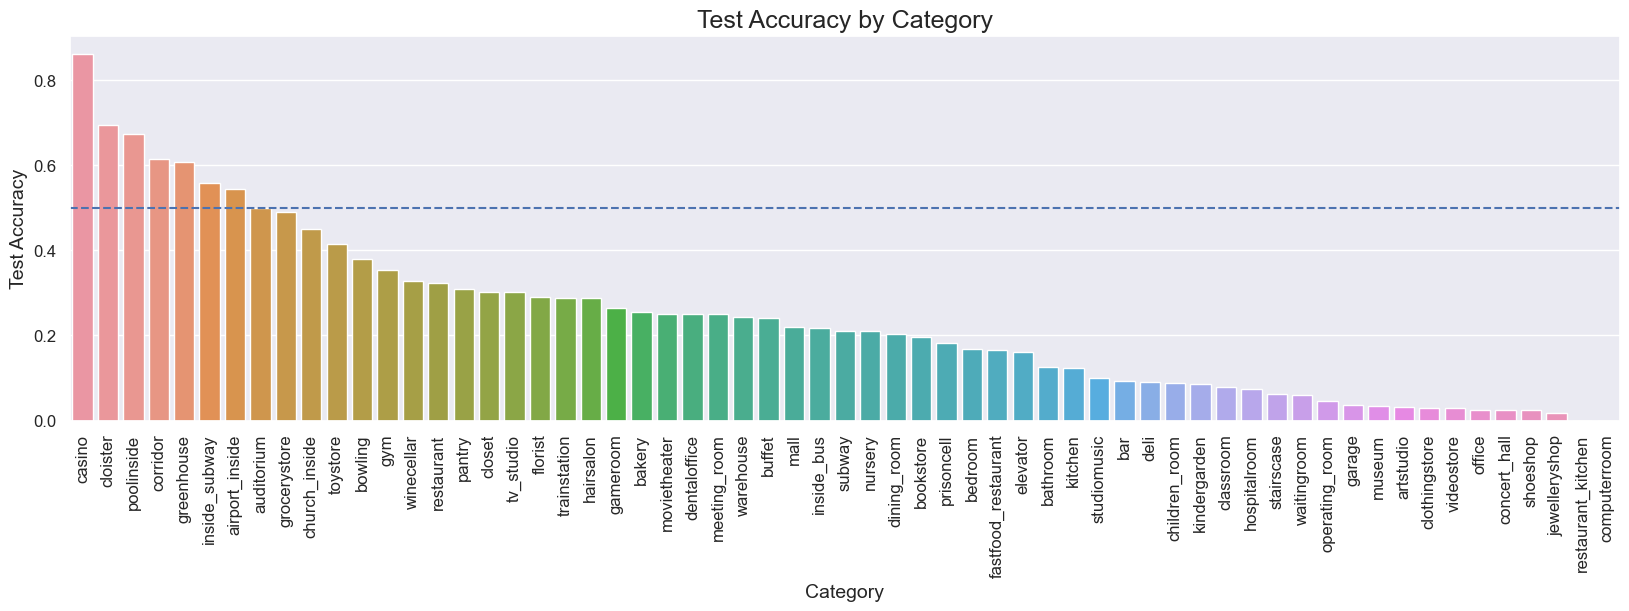

In [46]:
plot_test_metric_by_category(metrics_by_category_2)

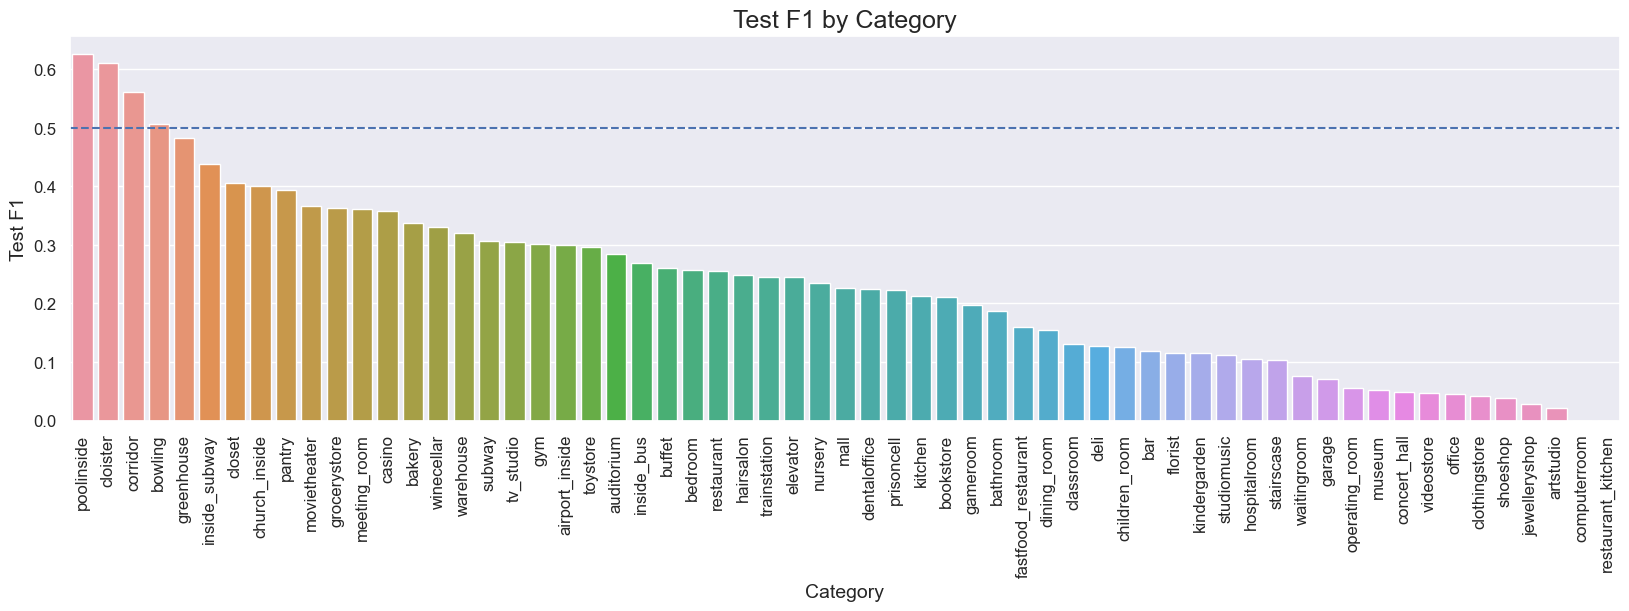

In [47]:
plot_test_metric_by_category(metrics_by_category_2, metric = "f1")

##### Find the proportion of categories that have accuracies greater than 50%.

In [48]:
print("proportion of categories with accuracies greater than 50% =", round(sum(metrics_by_category_2.accuracy > 0.5)/len(metrics_by_category_2), 4))

proportion of categories with accuracies greater than 50% = 0.1148


##### Compare the accuracies by category to those for the first model.

Find the proportion of categories that have higher accuracies with the second model compared to the first model.

In [49]:
print("proportion of categories with higher accuracies compared to the first model =", round(sum(metrics_by_category_2.accuracy > metrics_by_category_1.accuracy)/len(metrics_by_category_1), 4))

proportion of categories with higher accuracies compared to the first model = 0.6557


##### Plot a confusion matrix for the model.

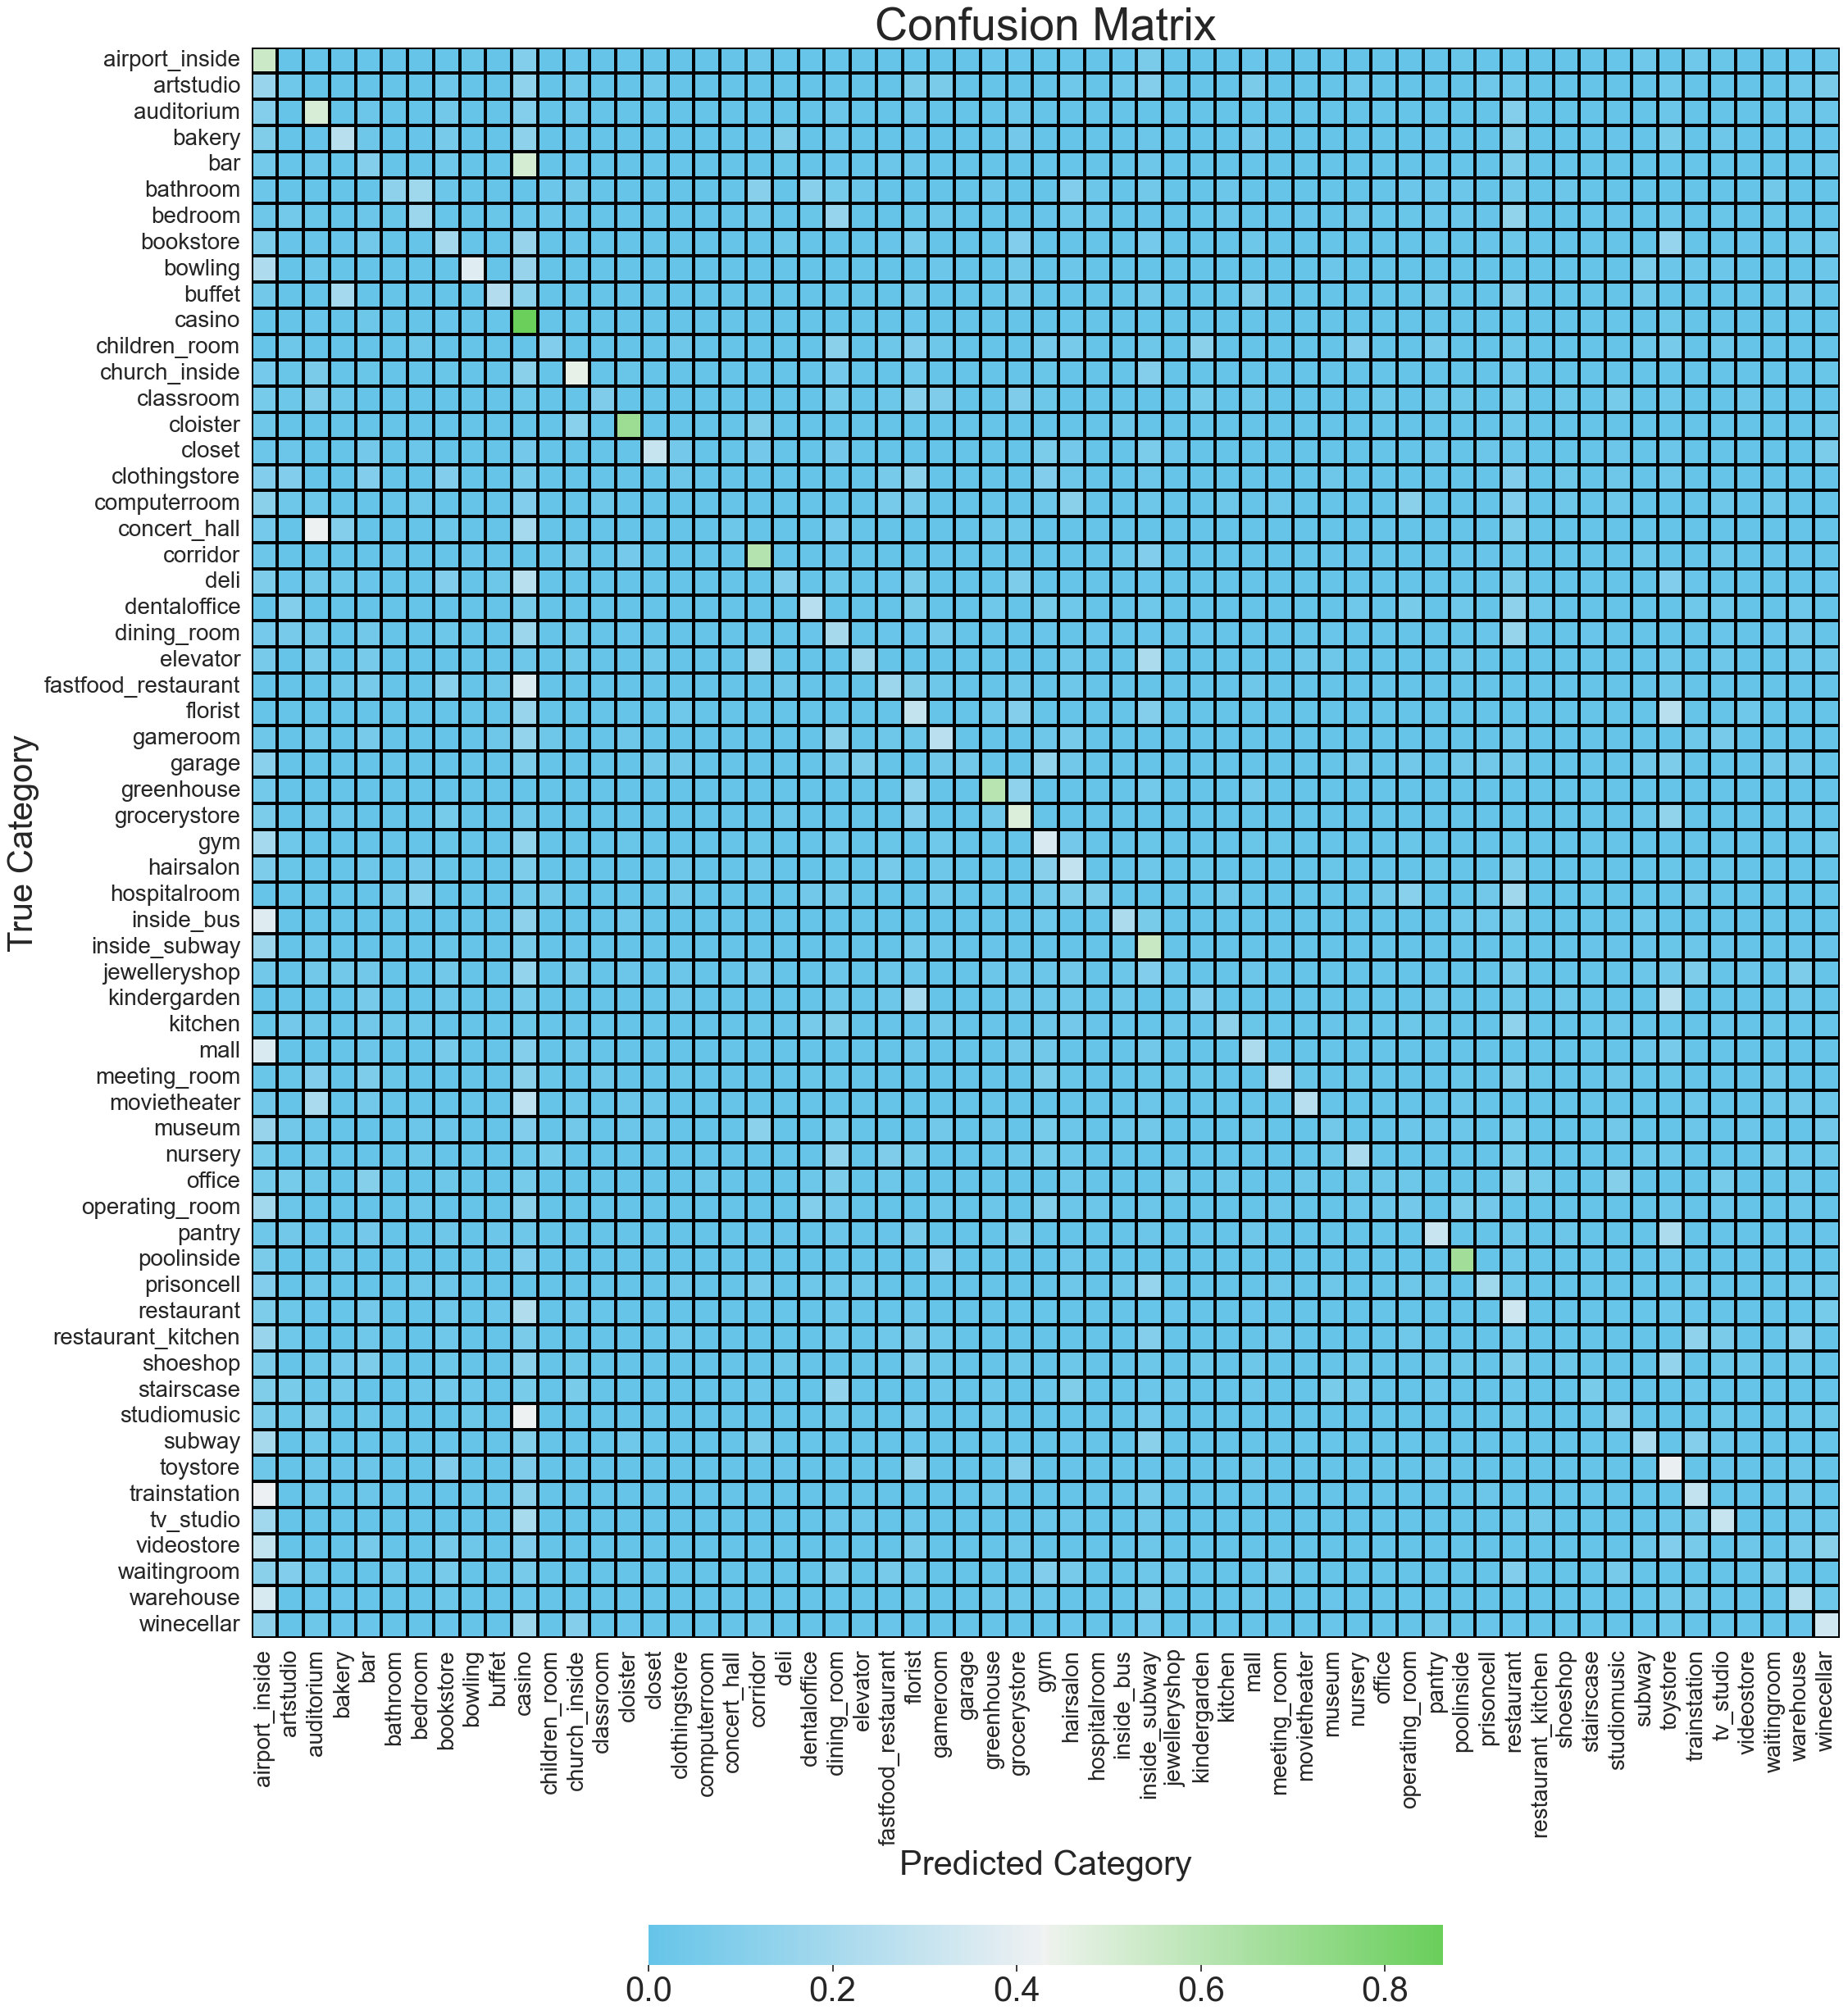

In [50]:
plot_confusion_matrix(true_and_predicted_2, img_dir)

##### Plot the training and validation loss and accuracy for each epoch of training.

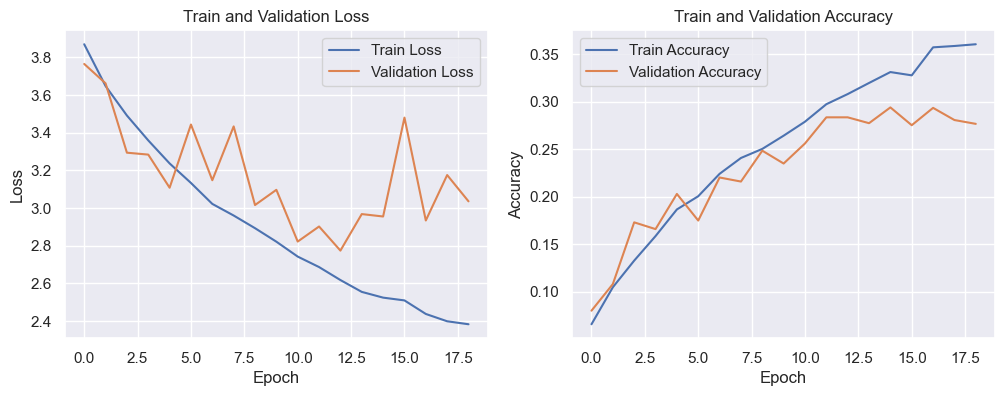

In [51]:
plot_loss_and_accuracy(history_2)

#### 4. Build a third CNN model based on the pre-trained model (transfer learning) and evaluate it on the test dataset.

##### Build and view a pre-trained CNN model.

The pre-trained model used here is **`tf.keras.applications.ConvNeXtTiny`**.

Note: Each Keras Application expects a specific kind of input preprocessing. **For ConvNeXt, preprocessing is included in the model using a `Normalization` layer.** ConvNeXt models expect their inputs to be float or uint8 tensors of pixels with values in the [0-255] range.

https://keras.io/api/applications/convnext/#convnexttiny-function

In [52]:
# specify the image shape
IMG_SHAPE = (image_height, image_width, image_channels)
# use a pre-trained network
pretrained_model = tf.keras.applications.ConvNeXtTiny(input_shape = IMG_SHAPE, include_top = False, weights = "imagenet") 
# do not retrain the convolutional base
pretrained_model.trainable = False

In [53]:
pretrained_model.summary(expand_nested = True)

Model: "convnext_tiny"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 convnext_tiny_prestem_normaliz  (None, 128, 128, 3)  0          ['input_1[0][0]']                
 ation (Normalization)                                                                            
                                                                                                  
 convnext_tiny_stem (Sequential  (None, 32, 32, 96)  4896        ['convnext_tiny_prestem_normaliza
 )                                                               tion[0][0]']         

In [54]:
inputs = tf.keras.Input(shape = IMG_SHAPE)

# augment the data
x = data_aug(inputs)
# use the pre-trained network
x = pretrained_model(x, training = False)
# convert the output to 2D
x = tf.keras.layers.Flatten()(x)
# add the top layer (classifier)
outputs = tf.keras.layers.Dense(len(img_dir), activation = "softmax")(x)

model_3 = tf.keras.Model(inputs, outputs)

model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 convnext_tiny (Functional)  (None, 4, 4, 768)         27820128  
                                                                 
 flatten_2 (Flatten)         (None, 12288)             0         
                                                                 
 dense_4 (Dense)             (None, 61)                749629    
                                                                 
Total params: 28,569,757
Trainable params: 749,629
Non-trainable params: 27,820,128
_________________________________________________________________


##### Compile the model and train it on the training dataset.

In [55]:
%%time
# compile the model
model_3.compile(optimizer = "rmsprop", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
# add early stopping
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 1)
# train the model
history_3 = model_3.fit(train_data, validation_data = val_data, epochs = 5, callbacks = [callback], verbose = 1)

Epoch 1/5
308/308 [==============================] - 4680s 15s/step - loss: 2.7094 - accuracy: 0.4567 - val_loss: 2.2127 - val_accuracy: 0.5823
Epoch 2/5
308/308 [==============================] - 3795s 12s/step - loss: 2.1399 - accuracy: 0.5861 - val_loss: 2.3881 - val_accuracy: 0.6029
Epoch 3/5
308/308 [==============================] - 3723s 12s/step - loss: 1.9703 - accuracy: 0.6286 - val_loss: 2.4936 - val_accuracy: 0.6117
Epoch 4/5
308/308 [==============================] - 3691s 12s/step - loss: 1.7977 - accuracy: 0.6633 - val_loss: 2.4972 - val_accuracy: 0.6361
Epoch 5/5
308/308 [==============================] - 3799s 12s/step - loss: 1.7093 - accuracy: 0.6810 - val_loss: 2.6864 - val_accuracy: 0.6169
CPU times: total: 3h 31min 26s
Wall time: 5h 28min 7s


##### Make predictions on the test dataset using the model.

In [56]:
%%time
true_and_predicted_3 = find_true_and_predicted_labels(model_3, val_data)

CPU times: total: 15min 5s
Wall time: 22min 40s


##### Evaluate the model by finding its test metrics:
+ accuracy
+ balanced accuracy
+ f1
+ weighted f1

In [57]:
test_metrics_3 = compute_test_metrics(true_and_predicted_3, models[2])

In [58]:
test_metrics_3

model  accuracy  balanced_accuracy      f1  weighted_f1
0  ConvNeXtTiny    0.6169             0.6002  0.5835       0.6138

In [59]:
model = test_metrics_3.iloc[0,0]
temp = test_metrics_3.transpose().iloc[1:]
temp["metric"] = temp.index
temp = temp.reset_index(drop = True)
temp.columns = ["value", "metric"]
temp = temp[["metric", "value"]]

In [60]:
print("Model:", model)
temp

Model: ConvNeXtTiny


metric   value
0           accuracy  0.6169
1  balanced_accuracy  0.6002
2                 f1  0.5835
3        weighted_f1  0.6138

##### Evaluate the model by finding its test metrics by category:
+ accuracy
+ precision
+ recall
+ f1

In [61]:
metrics_by_category_3 = compute_test_metrics_by_category(true_and_predicted_3, img_dir)

In [62]:
metrics_by_category_3.sort_values("accuracy", ascending = False)

category  correct  total  accuracy  precision    recall        f1
28     greenhouse       22     23  0.956522   0.846154  0.956522  0.897959
14       cloister       33     36  0.916667   0.868421  0.916667  0.891892
19       corridor       95    104  0.913462   0.500000  0.913462  0.646259
15         closet       39     43  0.906977   0.829787  0.906977  0.866667
34  inside_subway      131    145  0.903448   0.839744  0.903448  0.870432
..            ...      ...    ...       ...        ...       ...       ...
35  jewelleryshop       14     55  0.254545   0.241379  0.254545  0.247788
36   kindergarden        8     35  0.228571   0.615385  0.228571  0.333333
18   concert_hall        8     40  0.200000   0.727273  0.200000  0.313725
41         museum       10     58  0.172414   0.370370  0.172414  0.235294
20           deli        9     78  0.115385   0.500000  0.115385  0.187500

[61 rows x 7 columns]

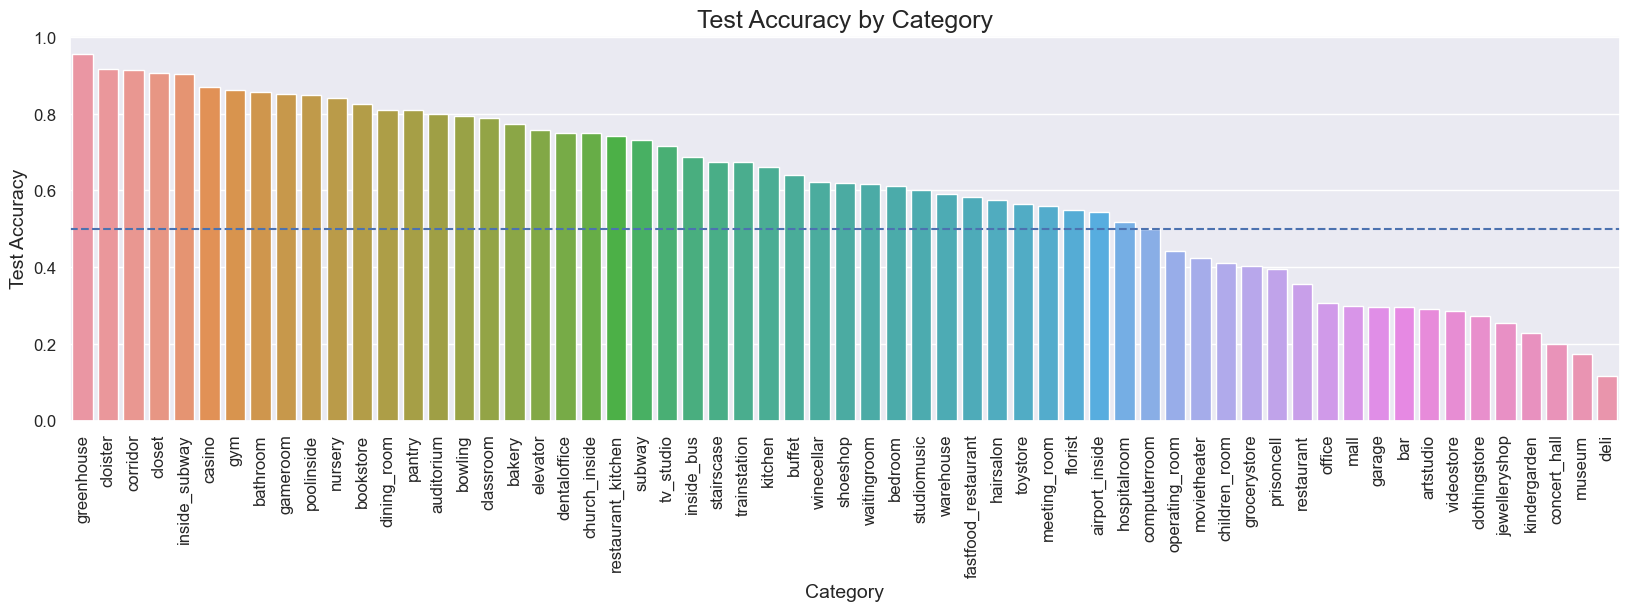

In [63]:
plot_test_metric_by_category(metrics_by_category_3)

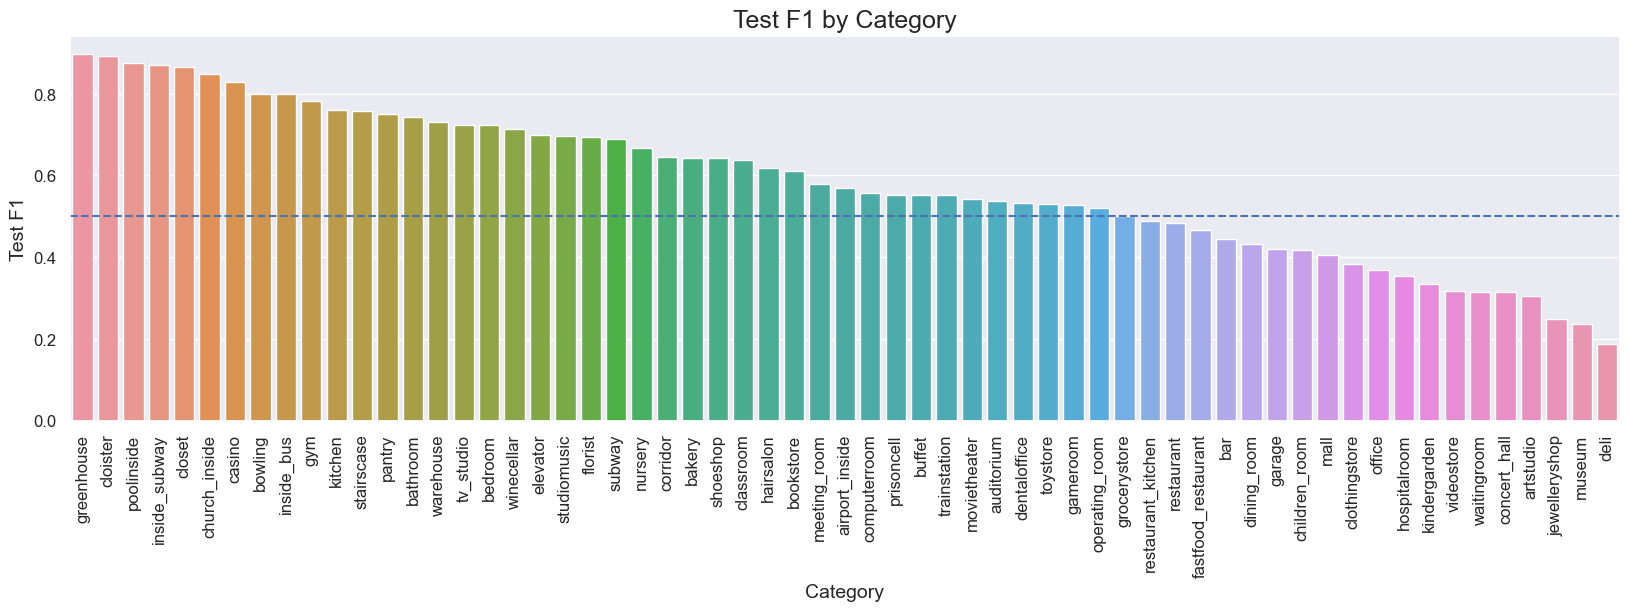

In [64]:
plot_test_metric_by_category(metrics_by_category_3, metric = "f1")

##### Find the proportion of categories that have accuracies greater than 50%.

In [65]:
print("proportion of categories with accuracies greater than 50% =", round(sum(metrics_by_category_3.accuracy > 0.5)/len(metrics_by_category_3), 4))

proportion of categories with accuracies greater than 50% = 0.6885


##### Compare the accuracies by category to those for the first two models.

Find the proportion of categories that have higher accuracies with the third model compared to the first model.  Also find the proportion of categories that have higher accuracies with the third model compared to the second model.

In [66]:
print("proportion of categories with higher accuracies compared to the first model =", round(sum(metrics_by_category_3.accuracy > metrics_by_category_1.accuracy)/len(metrics_by_category_1), 4))
print("proportion of categories with higher accuracies compared to the second model =", round(sum(metrics_by_category_3.accuracy > metrics_by_category_2.accuracy)/len(metrics_by_category_2), 4))

proportion of categories with higher accuracies compared to the first model = 1.0
proportion of categories with higher accuracies compared to the second model = 0.9672


##### Plot a confusion matrix for the model.

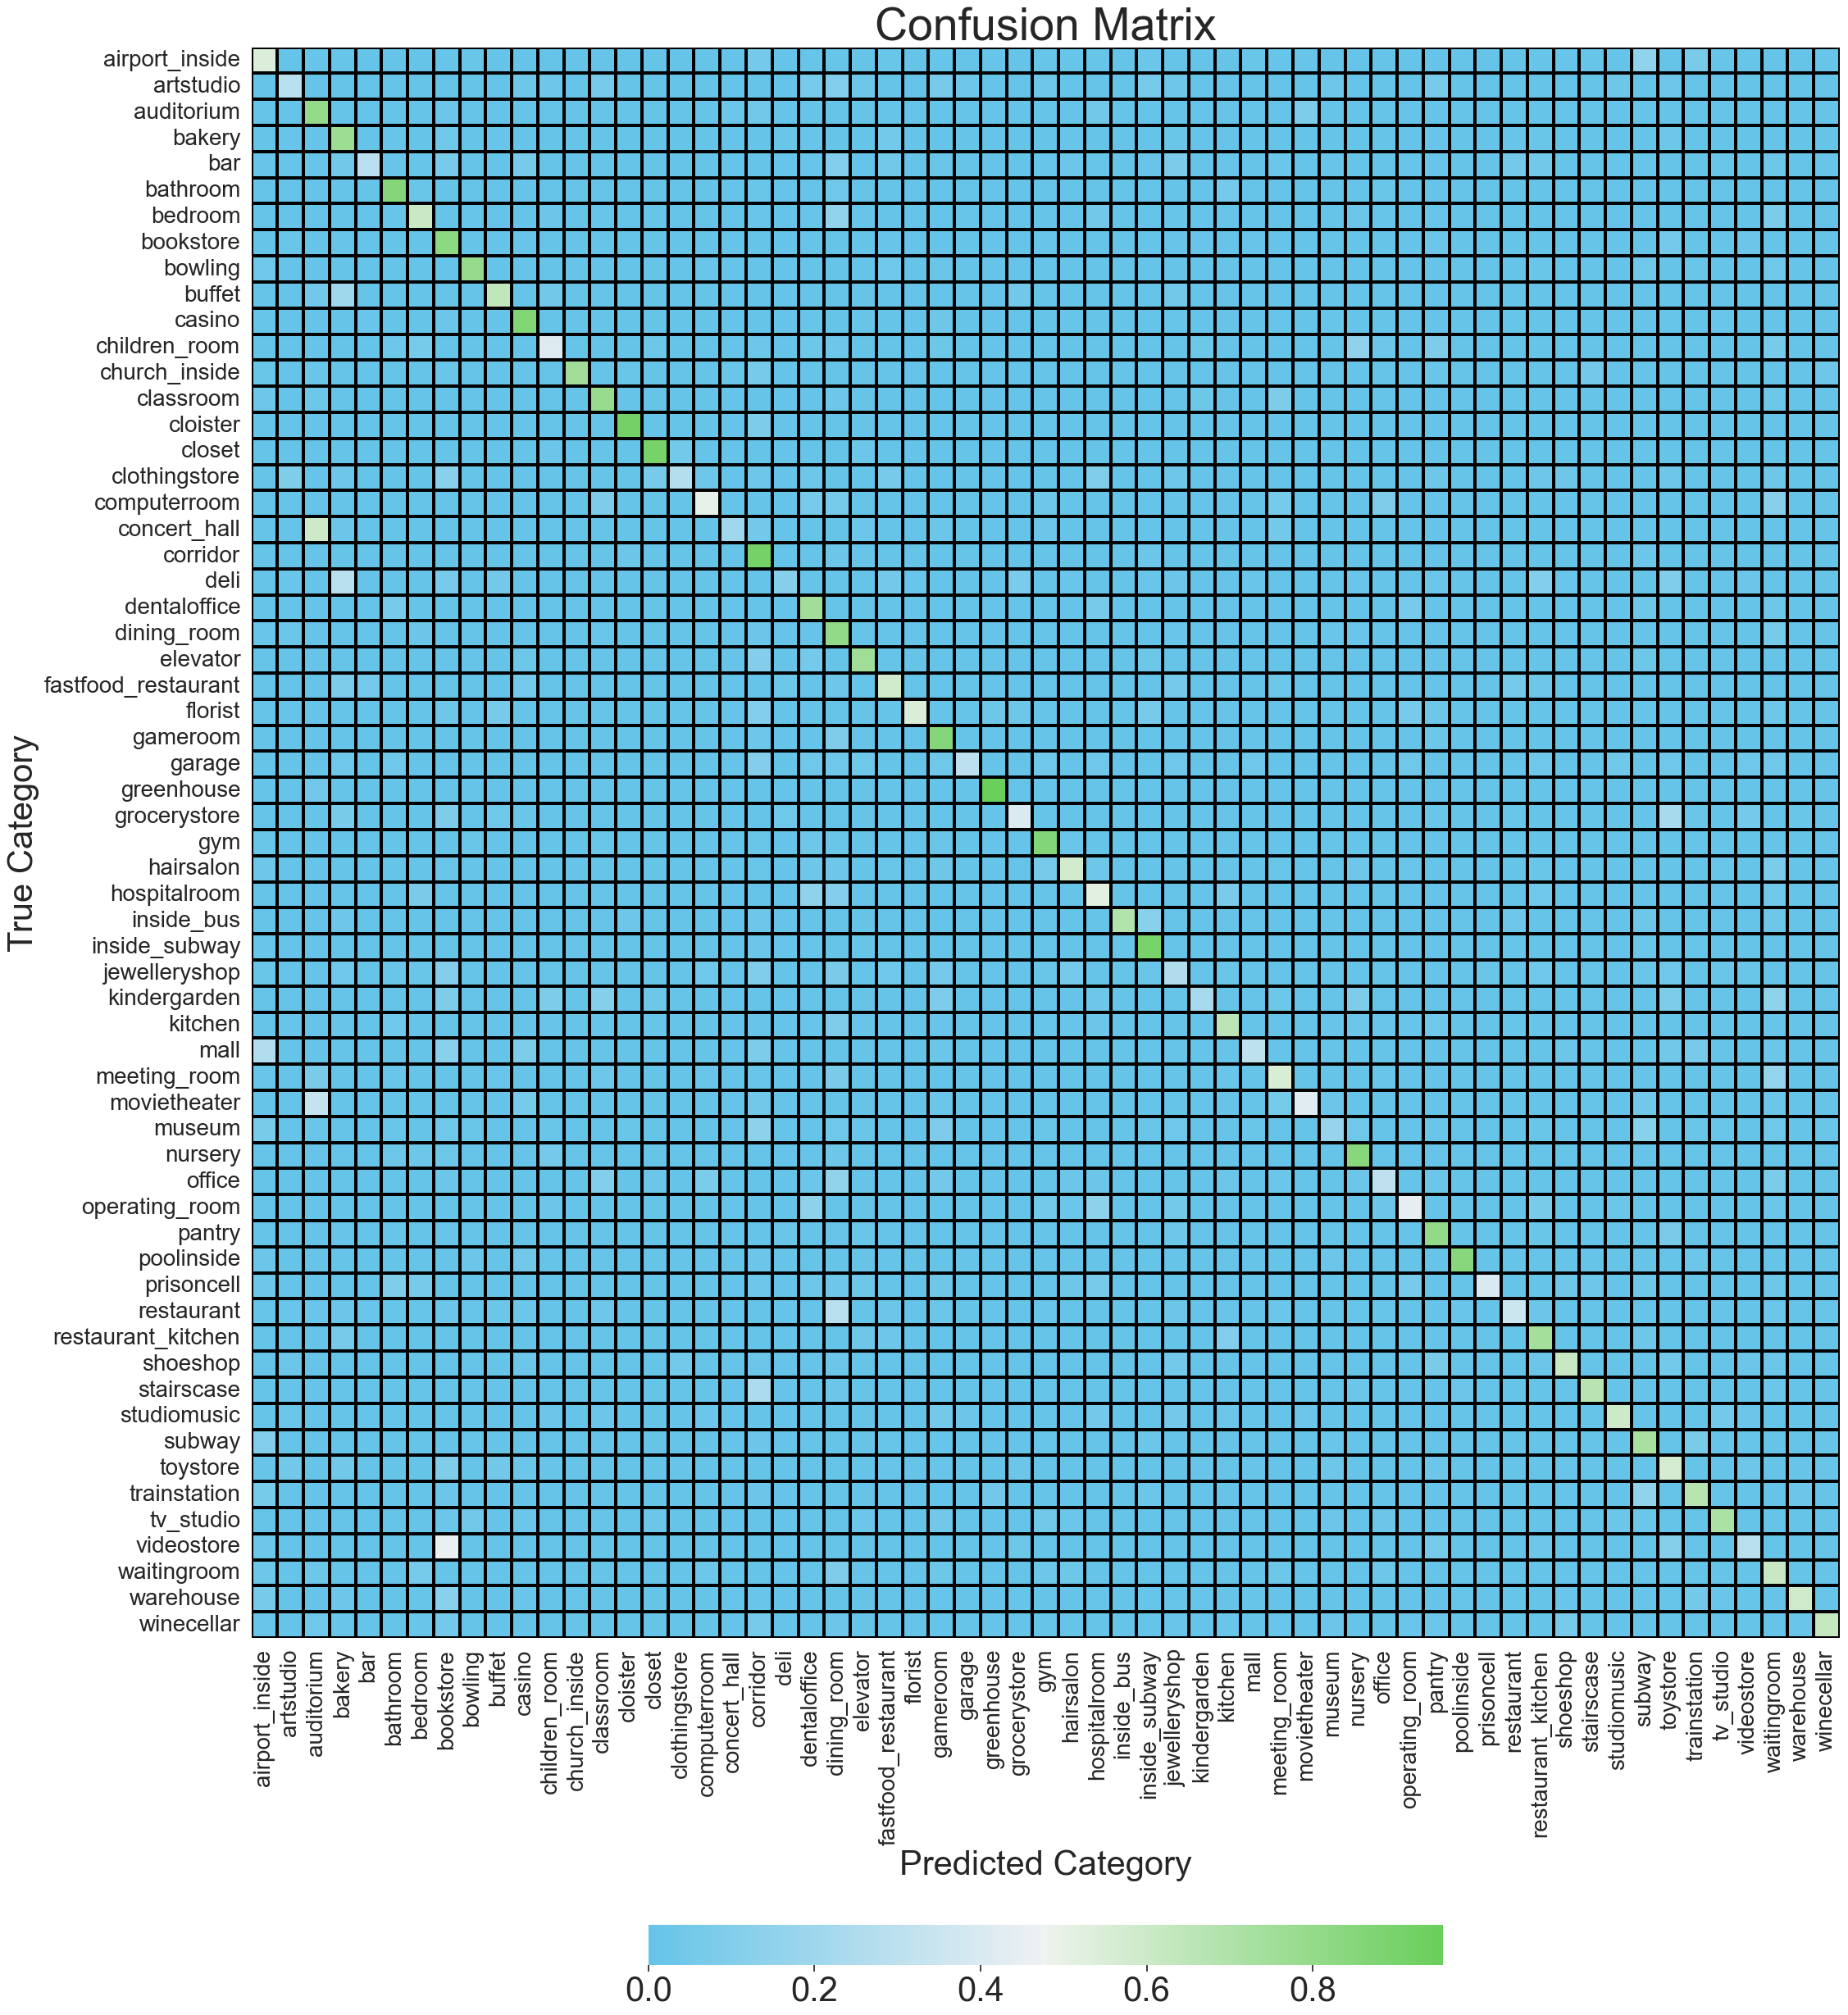

In [67]:
plot_confusion_matrix(true_and_predicted_3, img_dir)

##### Plot the training and validation loss and accuracy for each epoch of training.

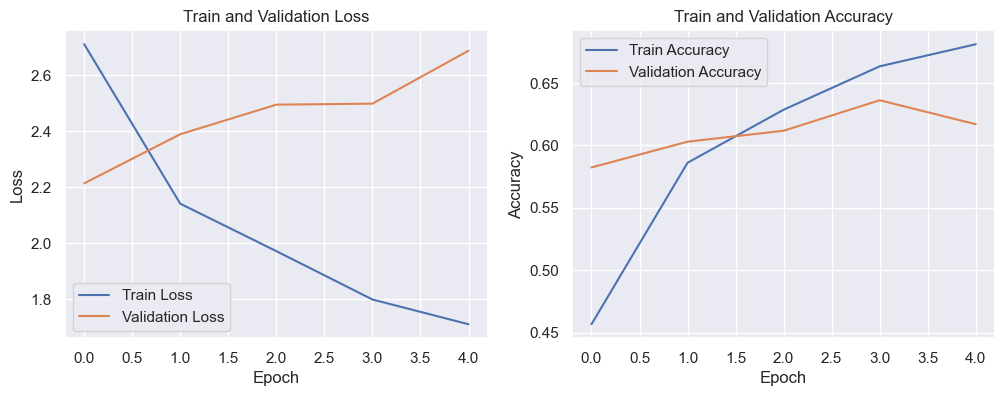

In [68]:
plot_loss_and_accuracy(history_3)

#### 5. Which model do you recommend for the model in Q2, Q3, and Q4? Justify your answer.
+ The model in Q2 has significant overfitting problems, and its metrics can certainly be improved.
    + This model performs much better than random guessing because there are 61 different categories, so random guessing would lead to an accuracy of about 1.6%.
    + However, this model's balanced accuracy is less than 20%, so it is not a great model.
+ Adding data augmentation and dropout to the model in Q3 dramatically reduces the overfitting problem present in the first model.  However, this model's metrics are still relatively low as its balanced accuracy is below 25%.
+ The model in Q4 (the pre-trained model ConvNeXtTiny) is a significant improvement compared to the two previous models.  Overfitting is not a major problem for this model while its accuracy and balanced accuracy are around 60%.  Therefore, **I recommend the model from Q4.**
    + The only downside of this model is that, because of its complexity, training and prediction take longer than for the two simpler models.

##### Create a dataframe with the test metrics for each model:
+ accuracy
+ balanced accuracy
+ f1
+ weighted f1

In [69]:
test_metrics = pd.DataFrame(columns = ["model", "accuracy", "balanced_accuracy", "f1", "weighted_f1"])
test_metrics_dfs = [test_metrics_1, test_metrics_2, test_metrics_3]
for i in range(len(test_metrics_dfs)):
    test_metrics = pd.concat([test_metrics, test_metrics_dfs[i]])
test_metrics = test_metrics.reset_index(drop = True)

In [70]:
test_metrics

model  accuracy  balanced_accuracy      f1  weighted_f1
0               Basic    0.2151             0.1673  0.1671       0.2034
1  Data Aug + Dropout    0.2766             0.2385  0.2303       0.2582
2        ConvNeXtTiny    0.6169             0.6002  0.5835       0.6138

##### Create a dataframe with the test metrics by category for each model:
+ accuracy
+ precision
+ recall
+ f1

In [71]:
category_test_metrics = pd.DataFrame(columns = ["model", "category", "accuracy", "precision", "recall", "f1"])
category_metrics_dfs = [metrics_by_category_1, metrics_by_category_2, metrics_by_category_3]
for i in range(len(category_metrics_dfs)):
    category_test_metrics = pd.concat([category_test_metrics,
                                       pd.DataFrame({"model": [models[i] for j in range(len(img_dir))],
                                                     "category": img_dir, 
                                                     "accuracy": category_metrics_dfs[i].accuracy, 
                                                     "precision": category_metrics_dfs[i].precision,
                                                     "recall": category_metrics_dfs[i].recall,
                                                     "f1": category_metrics_dfs[i].f1})])
category_test_metrics = category_test_metrics.reset_index(drop = True)

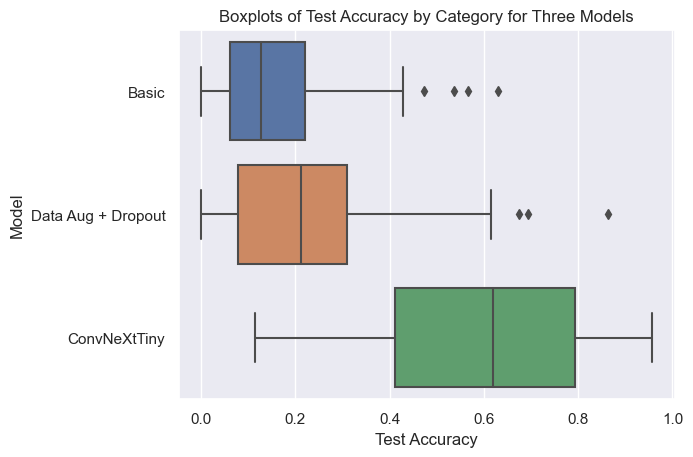

In [72]:
sns.boxplot(data = category_test_metrics, x = "accuracy", y = "model")
plt.xlabel("Test Accuracy")
plt.ylabel("Model")
plt.title("Boxplots of Test Accuracy by Category for Three Models");

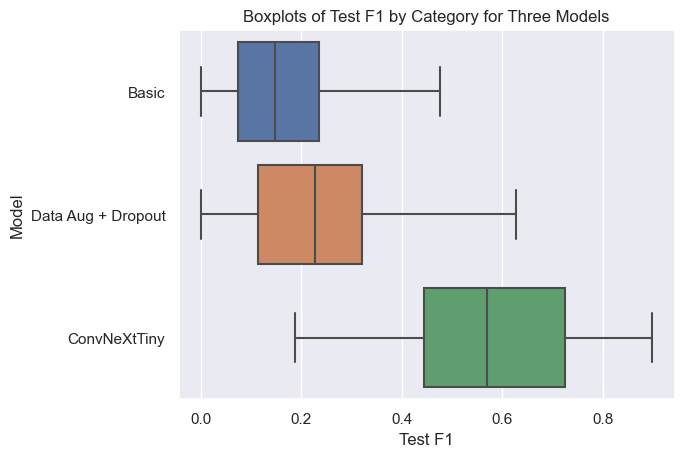

In [73]:
sns.boxplot(data = category_test_metrics, x = "f1", y = "model")
plt.xlabel("Test F1")
plt.ylabel("Model")
plt.title("Boxplots of Test F1 by Category for Three Models");